```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import pyopencl
import subprocess
import os
import StringIO
import gc
import datetime

#Set large figure sizes
#Note, this prevents nice figures for articles...
#rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import FBL, CTCS, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, CDKLM16, DataOutput, PlotHelper

In [2]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  GeForce 840M


In [3]:
#Misc plotting setup

def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1', 5]) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':', '-.']) +
                       #cycler('markersize', [5, 5, 5, 5, 5, 5]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k', 'k']) )    

#plt.rc('font', size=18)
#plt.rc('xtick', labelsize='large')
#plt.rc('ytick', labelsize='large')
#plt.rc('legend', fontsize='medium')
plt.rc('legend', markerscale=1.0)
plt.rc('lines', markersize=6)
plt.rc('lines', markeredgewidth=1.5)
plt.rc('savefig', dpi=200)

In [4]:
def save_figure(fig, stem):
    fig_filename = "convergence_shock1d_" + stem + ".pdf"
    
    image_text = fig_filename + "\nCreated " + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    #ax = fig.gca()
    #pos1 = ax.get_position() # get the original position 
    #pos2 = [pos1.x0 + 0.3, pos1.y0 + 0.3,  pos1.width / 2.0, pos1.height / 2.0] 
    #ax.set_position(pos2) # set a new position
    
    #fig.gca().annotate(image_text, xy=(1.1, 0), xycoords='figure fraction', fontsize=10,
    #                   horizontalalignment='right', verticalalignment='bottom')
    t = plt.figtext(-0.1, .9, image_text, rotation='vertical')
    
    legend = fig.gca().legend_
    if (legend != None):
        fig.savefig(fig_filename, bbox_extra_artists=(legend,t, ), bbox_inches='tight')
    else:
        fig.savefig(fig_filename)

In [5]:
def gen_reference(nx):
    csv_filename = 'shock1d_ref_nx=' + str(nx) + '.csv'

    #If we do not have the data, generate it    
    if (not os.path.isfile(csv_filename)):
        print "Generating new reference!"
        swashes_path = r'C:\Users\anbro\Documents\programs\SWASHES-1.03.00_win\bin\swashes_win.exe'

        swashes_args = [\
                        '1', # 1D problems \
                        '3', # Dam breaks \
                        '1', # Domain 1 \
                        '1', # Wet domain no friction
                        str(nx) #Number of cells X
                       ]

        with open(csv_filename, 'w') as csv_file:
            p = subprocess.check_call([swashes_path] + swashes_args, stdout=csv_file)

    reference = np.genfromtxt(csv_filename, comments='#', delimiter='\t', skip_header=0, usecols=(0, 1, 2))
    x, h, u = reference[:, 0], reference[:, 1], reference[:, 2]
    return x, h, h*u

In [6]:
def gen_test_data(nx, num_ghost_cells):
    ny = 1
    dx = 10.0 / float(nx)
    dy = 1.0

    h = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create dam break
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*i

            if (x < 5):
                h[j+num_ghost_cells, i+num_ghost_cells] = 0.005
            else:
                h[j+num_ghost_cells, i+num_ghost_cells] = 0.001
    
    return h, hu, hv, dx, dy, nx, ny

In [7]:
def run_benchmark(simulator, nx, ghost_cells, g=9.81, courant_number=None, dt_in=None):    
    datafilename = "shock1d_nx=" + str(simulator) + "_" + str(nx) + ".npz"

    #If we do not have the high-res data, generate it    
    if (not os.path.isfile(datafilename)):
        
        h0, hu0, hv0, dx, dy, nx, ny = gen_test_data(nx, ghost_cells)
        
        max_u = 1.0; #Estimate of maximum velocity for dt
        if (dt_in and courant_number):
            raise Exception("Both dt and courant number specified")
        elif (dt_in and not courant_number):
            dt = dt_in
        elif (courant_number and not dt_in):
            dt = courant_number * dx / (max_u + np.sqrt(g*0.6))
        else:
            courant_number = 0.9 / float(ghost_cells)
            dt = courant_number * dx / (max_u + np.sqrt(g*0.6))
            

        #Initialize simulator
        sim = simulator(cl_ctx,
                        h0, hu0, hv0, \
                        nx, ny, \
                        dx, dy, dt, \
                        g)

        t = sim.step(6.0)
        h, hu, hv = sim.download()

        h = h[ghost_cells, ghost_cells:-ghost_cells]
        hu = hu[ghost_cells, ghost_cells:-ghost_cells]
        hv = hv[ghost_cells, ghost_cells:-ghost_cells]
        
        np.savez_compressed(datafilename, h=h, hu=hu, hv=hv)
        
        gc.collect() # Force run garbage collection to free up memory
        
        
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        #hu = data['hu']
        #hv = data['hv']
        hu = None
        hv = None
        
    gc.collect() # Force run garbage collection to free up memory
        
    return h, hu, hv

In [8]:
def downsample(highres_solution, factor):
    nx = highres_solution.size / factor
    return highres_solution.reshape([nx, factor]).mean(1)

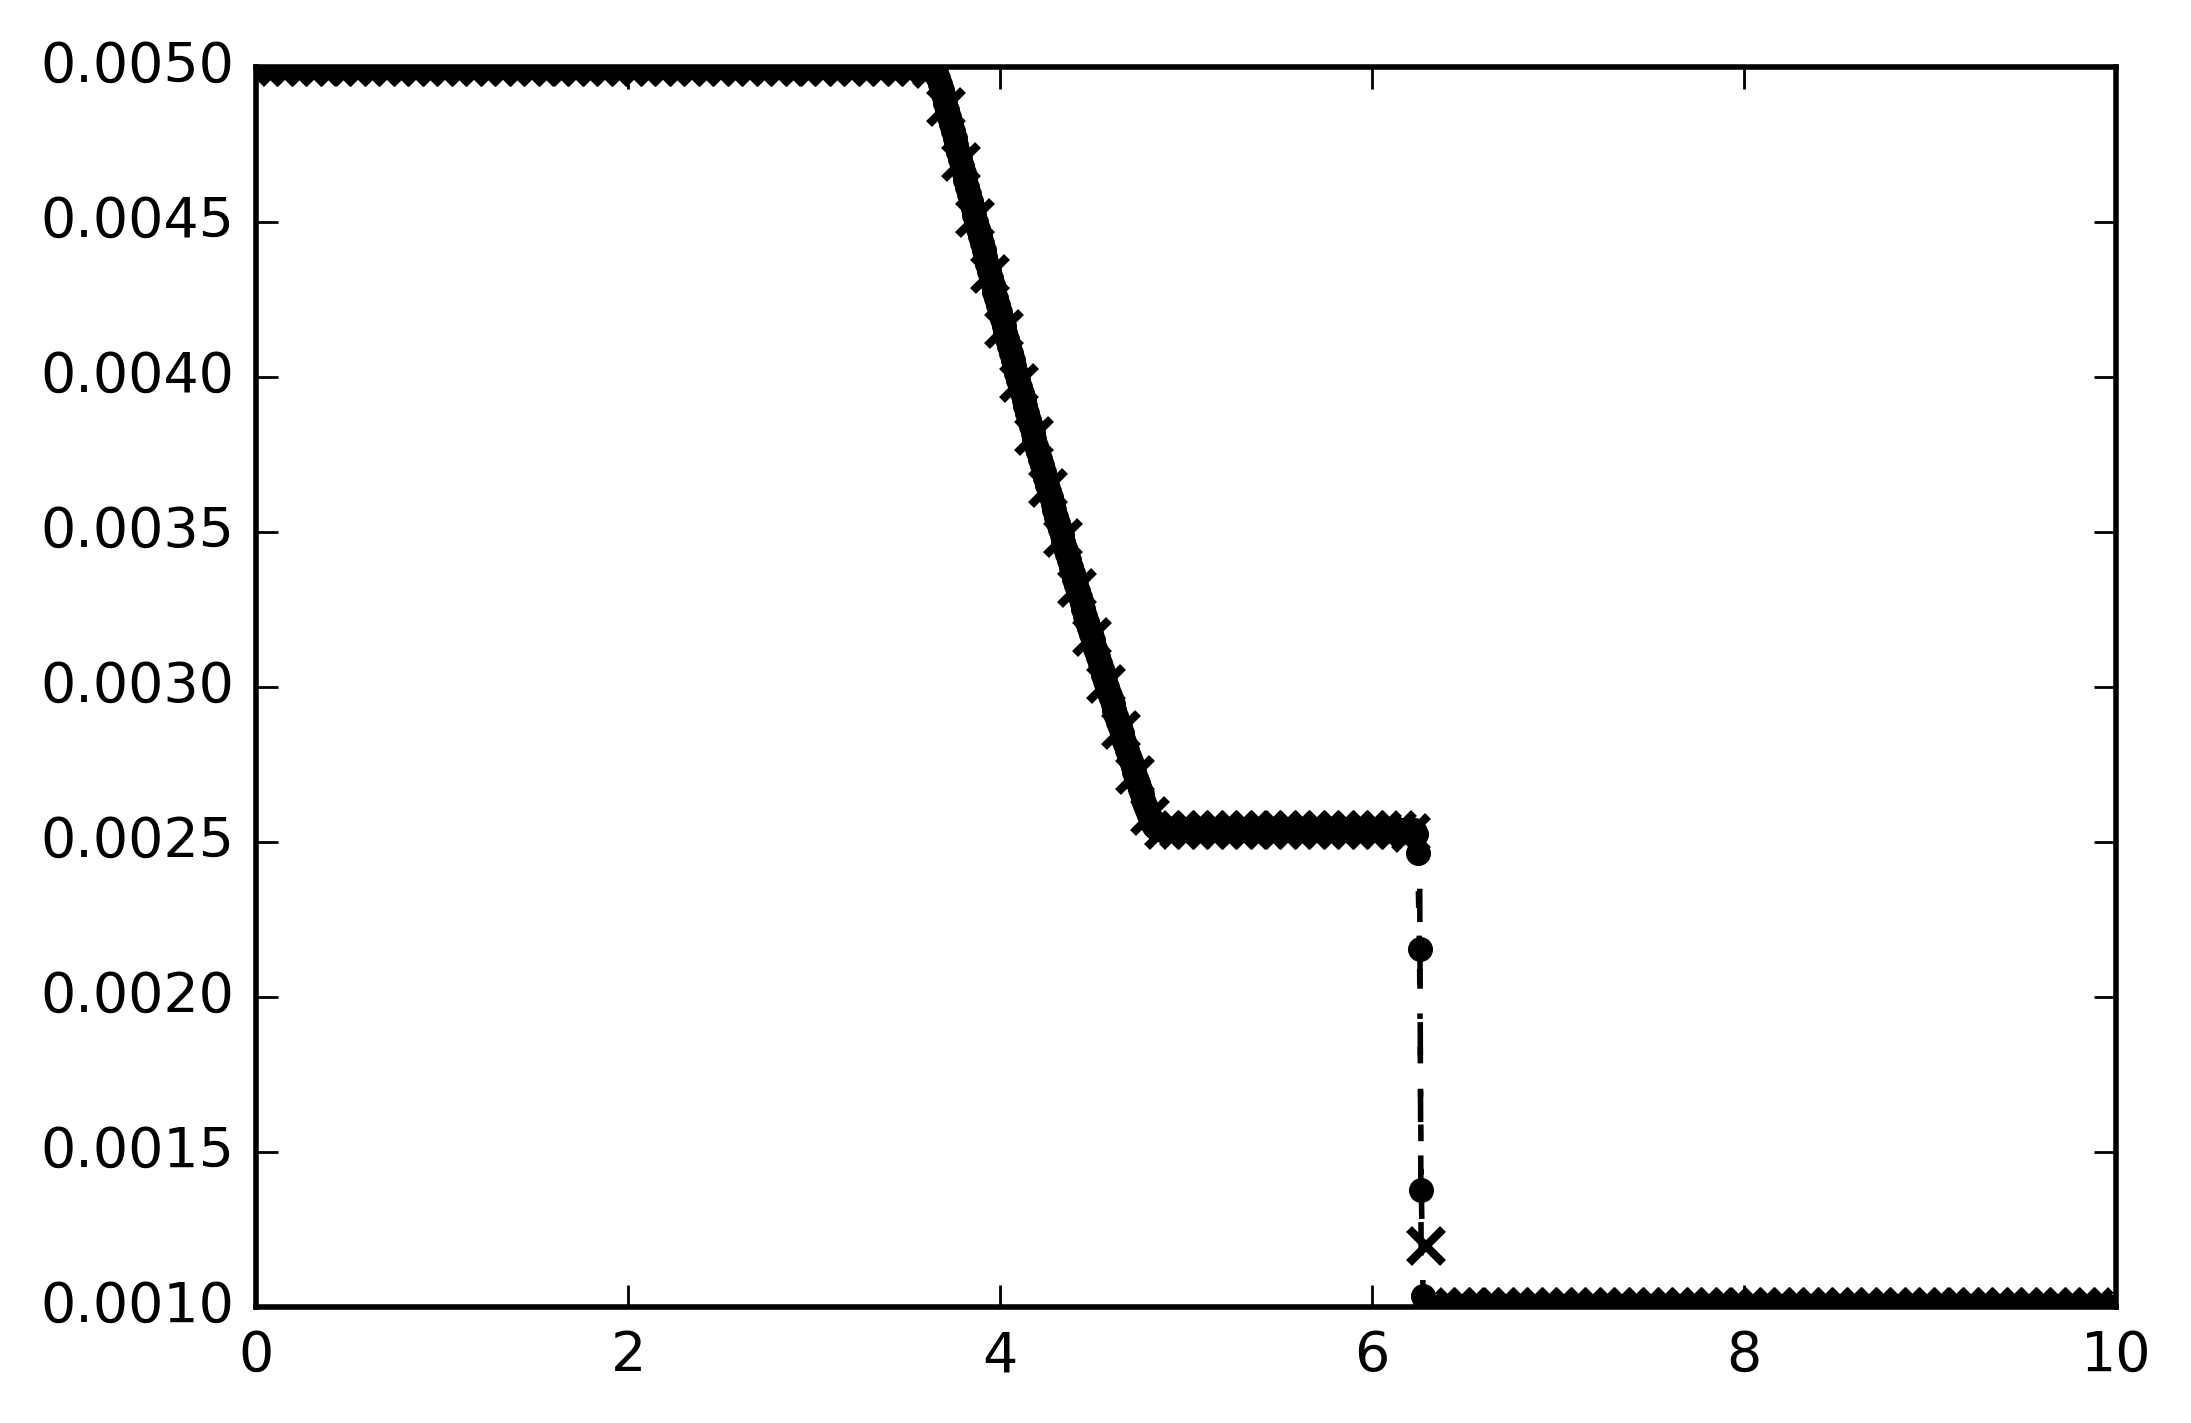

In [9]:
h, hu, hv = run_benchmark(KP07.KP07, 1024, 2)
ref_x, ref_h, ref_hu = gen_reference(1024)

x = np.linspace(0.5, 1023.5, 1024)/1024.0*10.0

rh = downsample(h, 8)
rx = downsample(x, 8)

fig = plt.figure()
setBwStyles(fig.gca())
plt.plot(x, h)
plt.plot(ref_x, ref_h, 'k--')
plt.plot(rx, rh, 'x')
plt.show()

In [10]:
domain_sizes = [128, 256, 512, 1024, 2048, 4096]
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, WAF.WAF, KP07.KP07, KP07_dimsplit.KP07_dimsplit]
simulator_ghost_cells = [1, 1, 1, 2, 2, 2, 2]
simulator_names = ['LxF', 'FORCE', 'HLL', 'HLL2', 'WAF', 'KP07', 'KP07 dimsplit']
simulator_reference = [KP07.KP07, KP07.KP07, KP07.KP07, HLL2.HLL2, WAF.WAF, KP07.KP07, KP07_dimsplit.KP07_dimsplit]
#simulator_courant_numbers = [0.95, 0.95, None, None, None, None]
simulator_courant_numbers = [0.95, 0.95, 0.95, 0.45, 0.45, 0.45, 0.45]
const_dt = 0.45 * (100.0/float(max(domain_sizes))) / (1.0 + np.sqrt(9.81*0.6))
#simulator_dt = [None, None, const_dt, const_dt, const_dt, const_dt]
simulator_dt = [None, None, None, None, None, None, None]

LxF


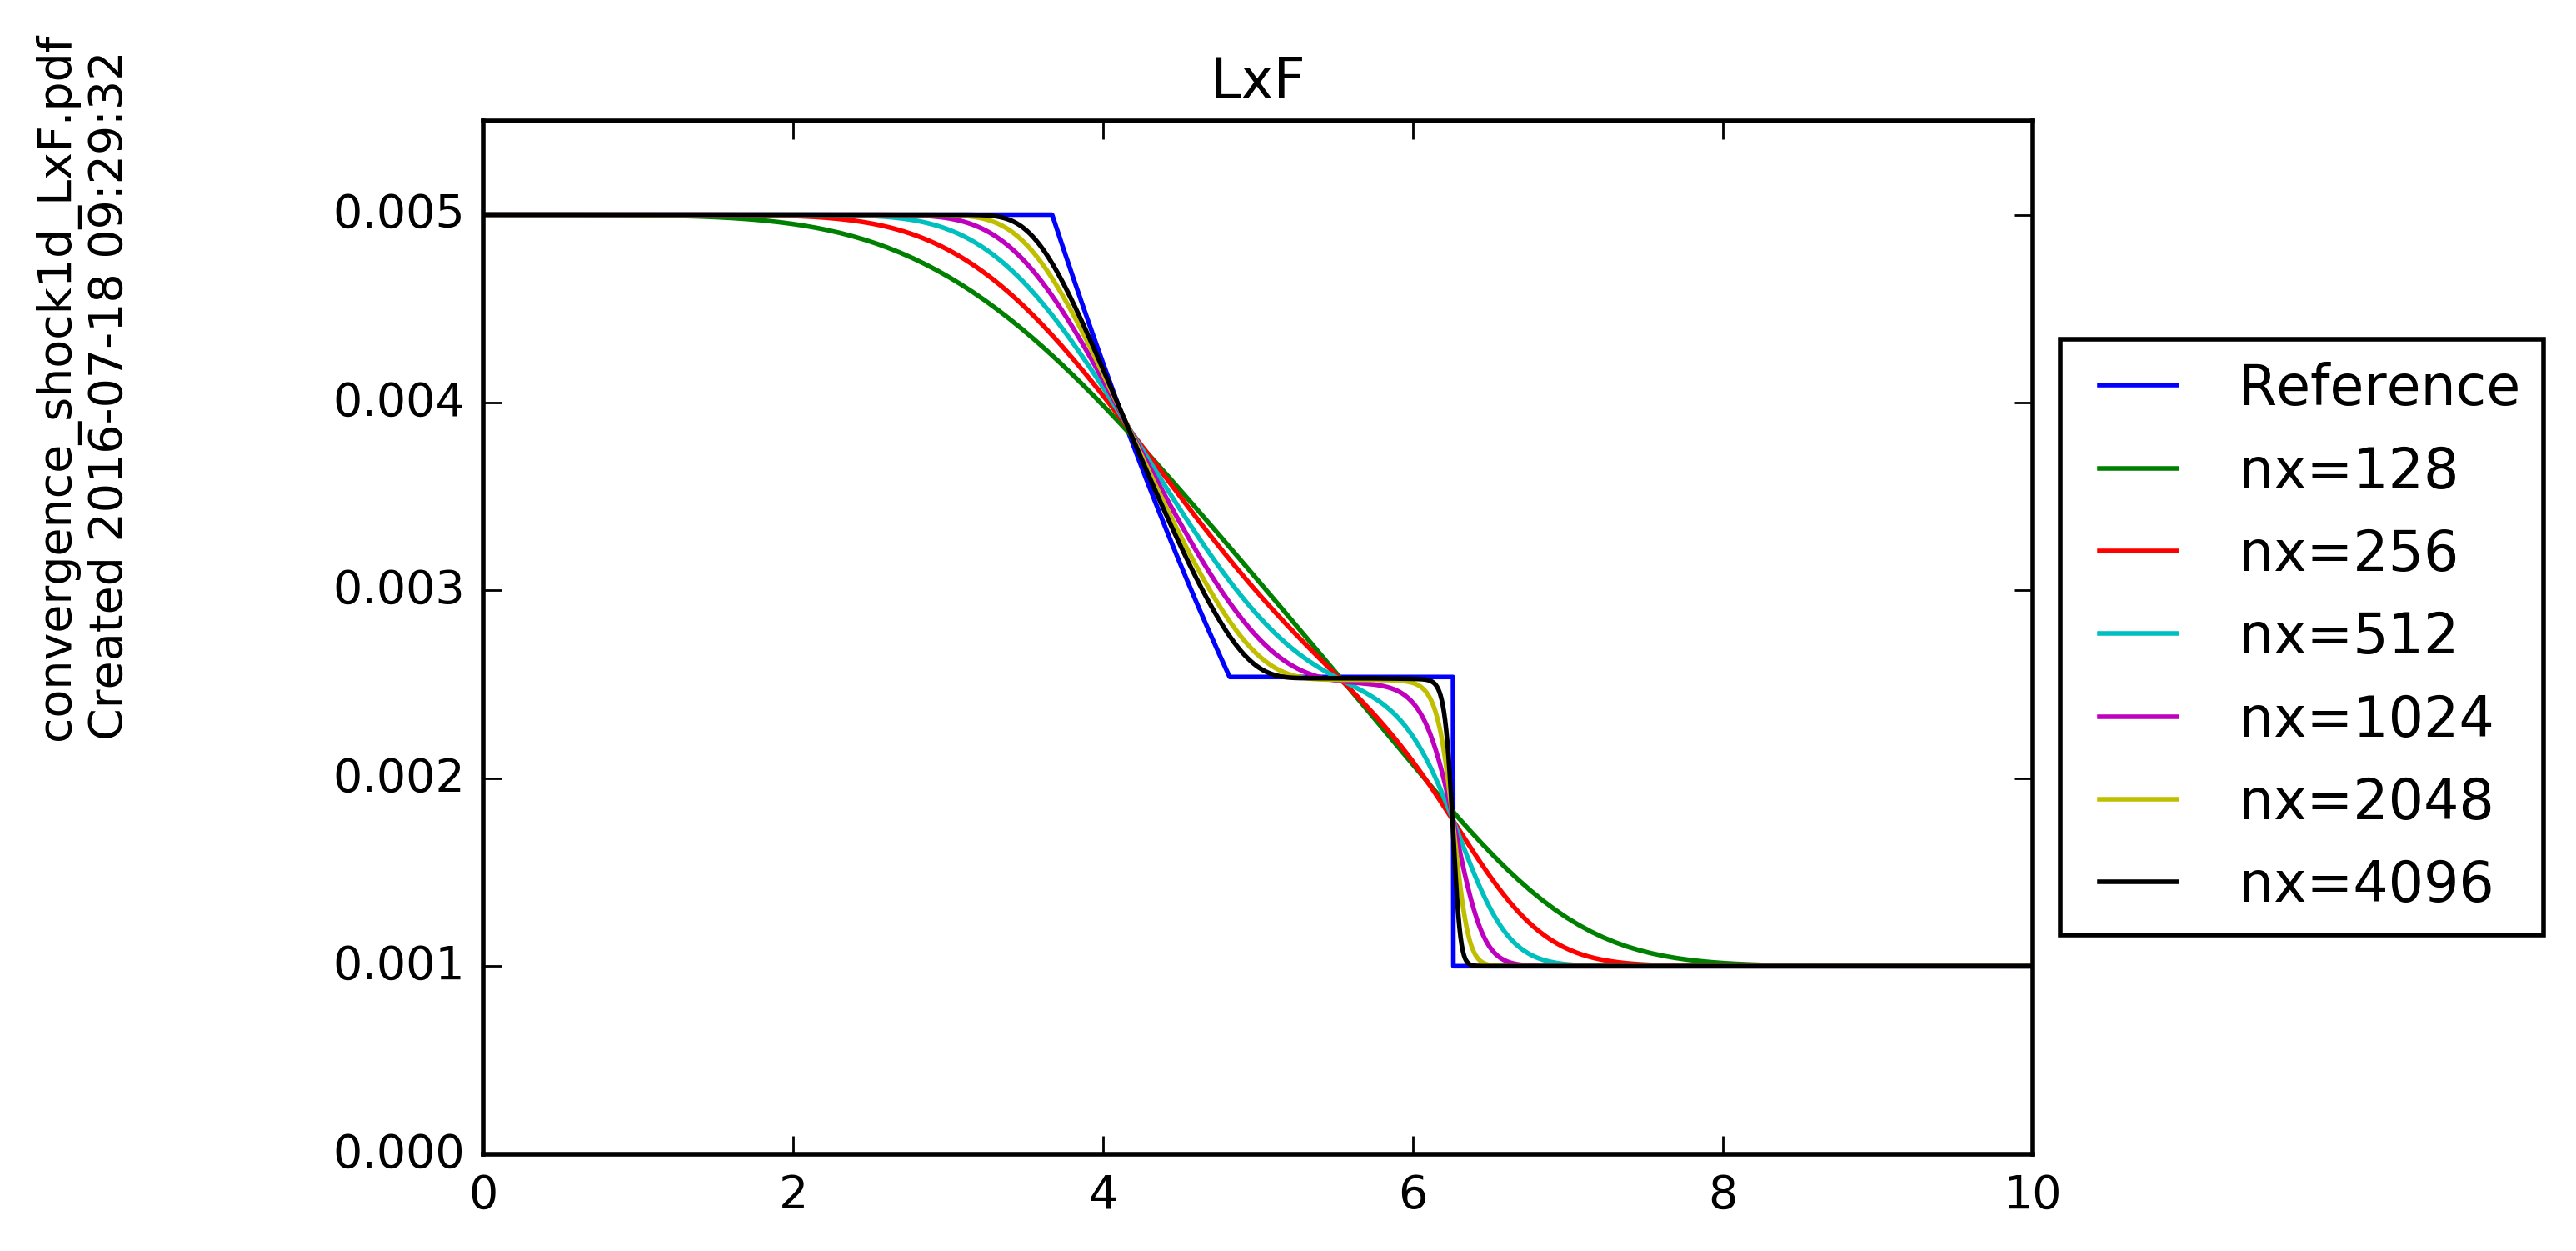

FORCE


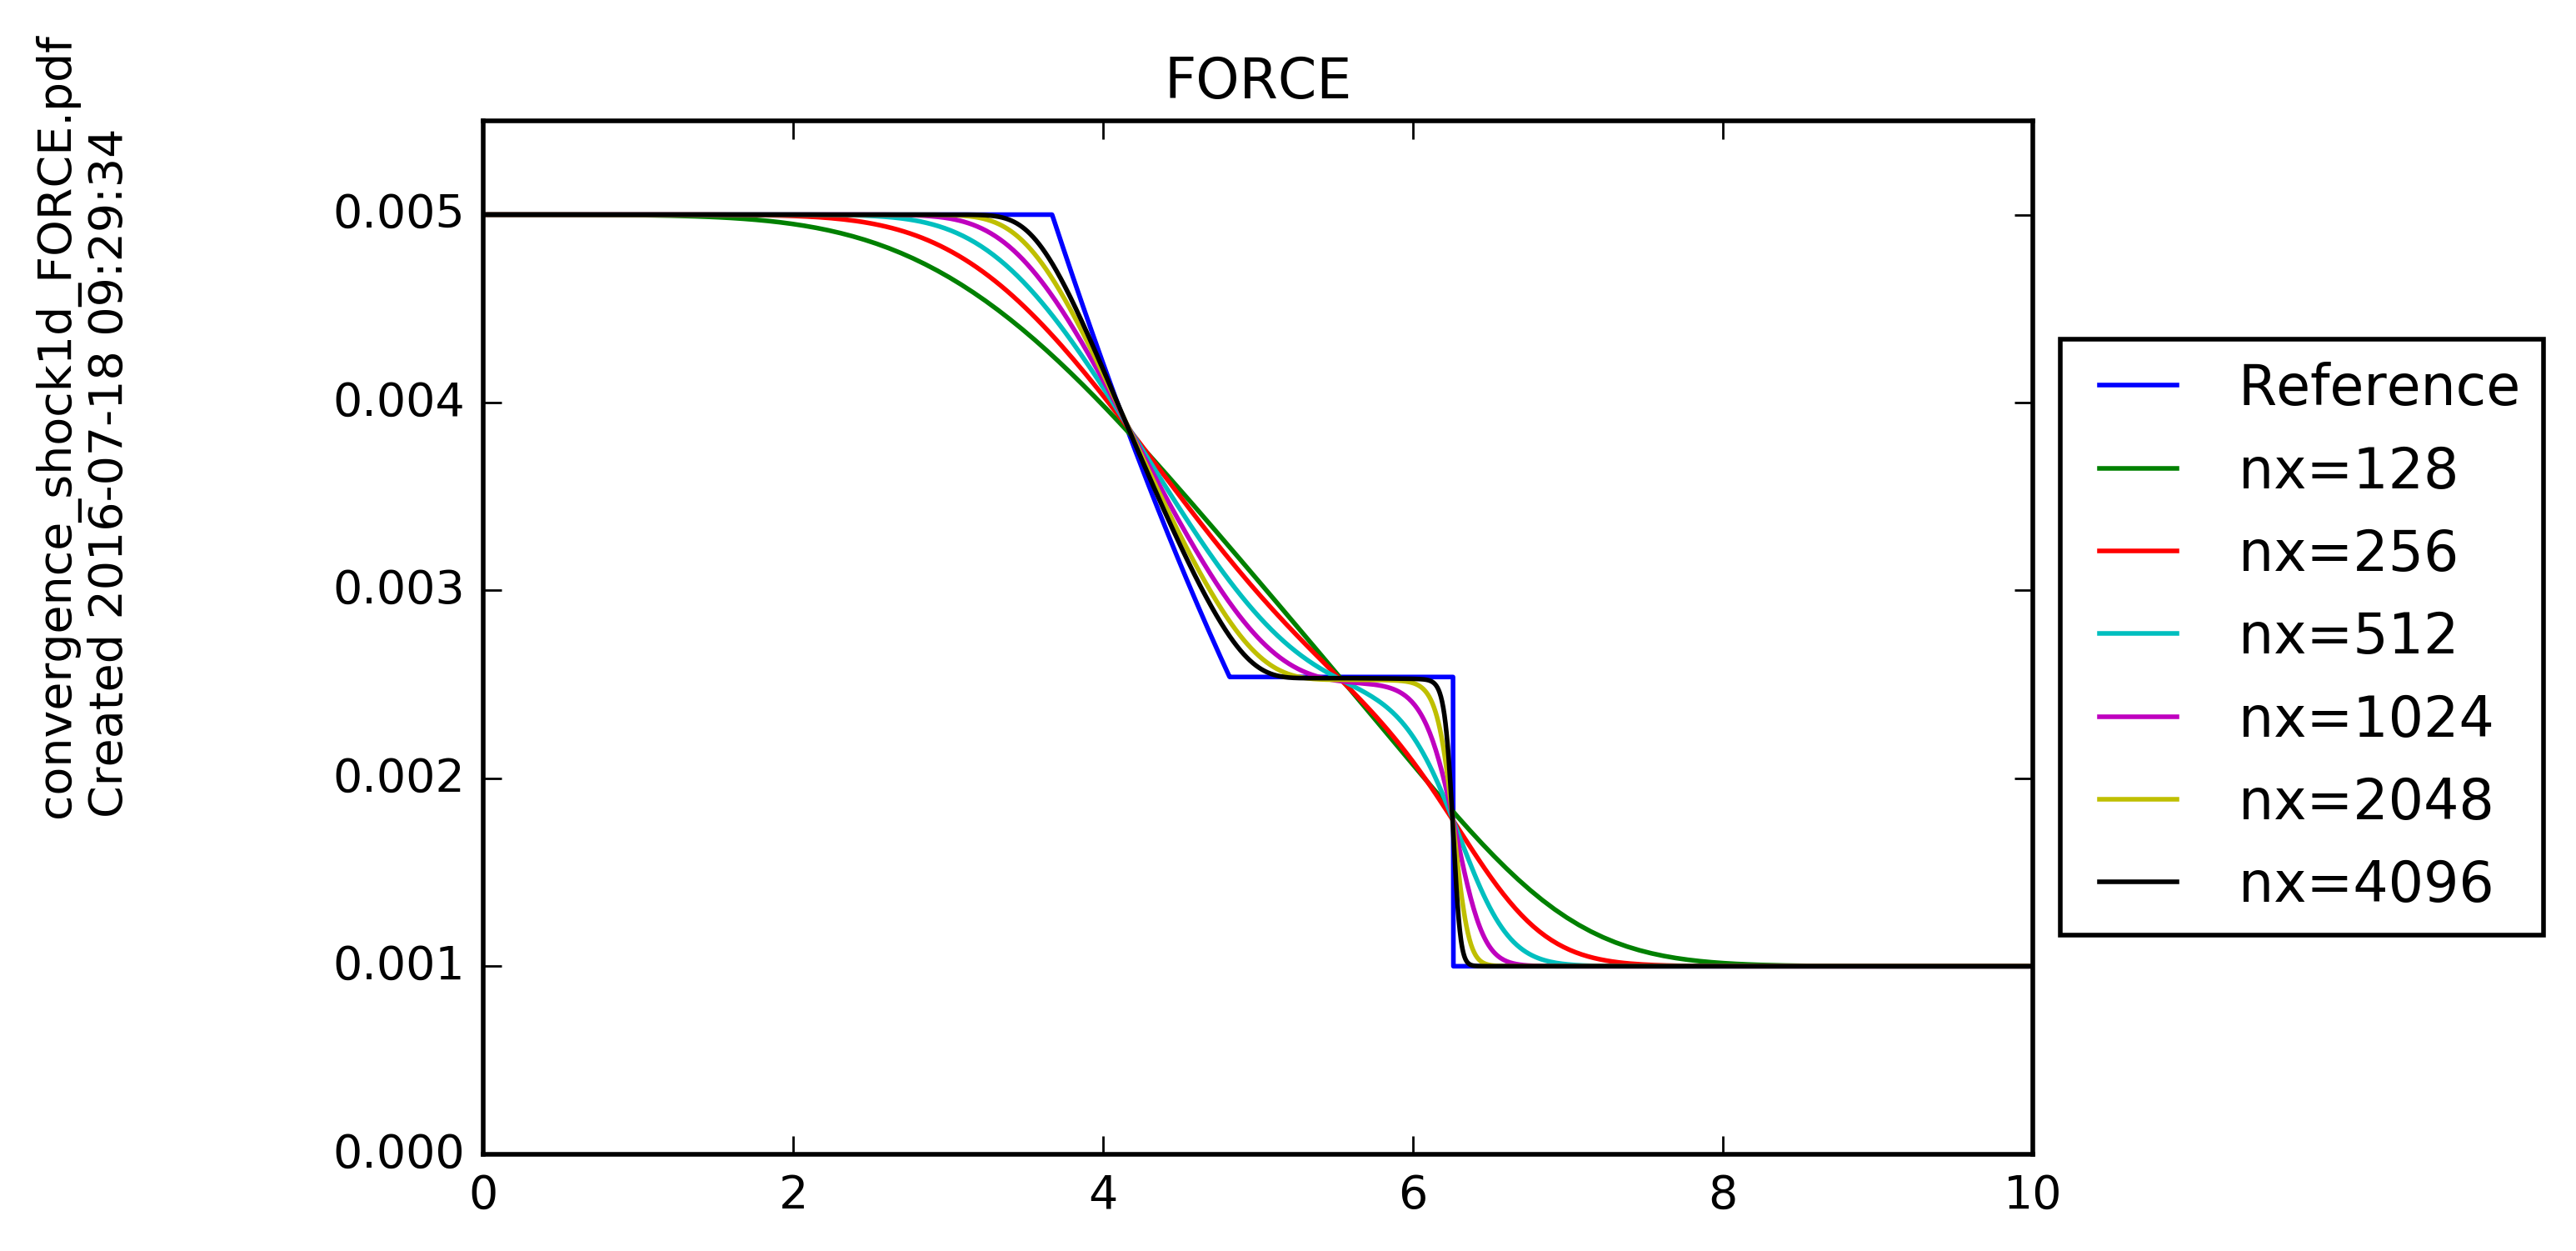

HLL


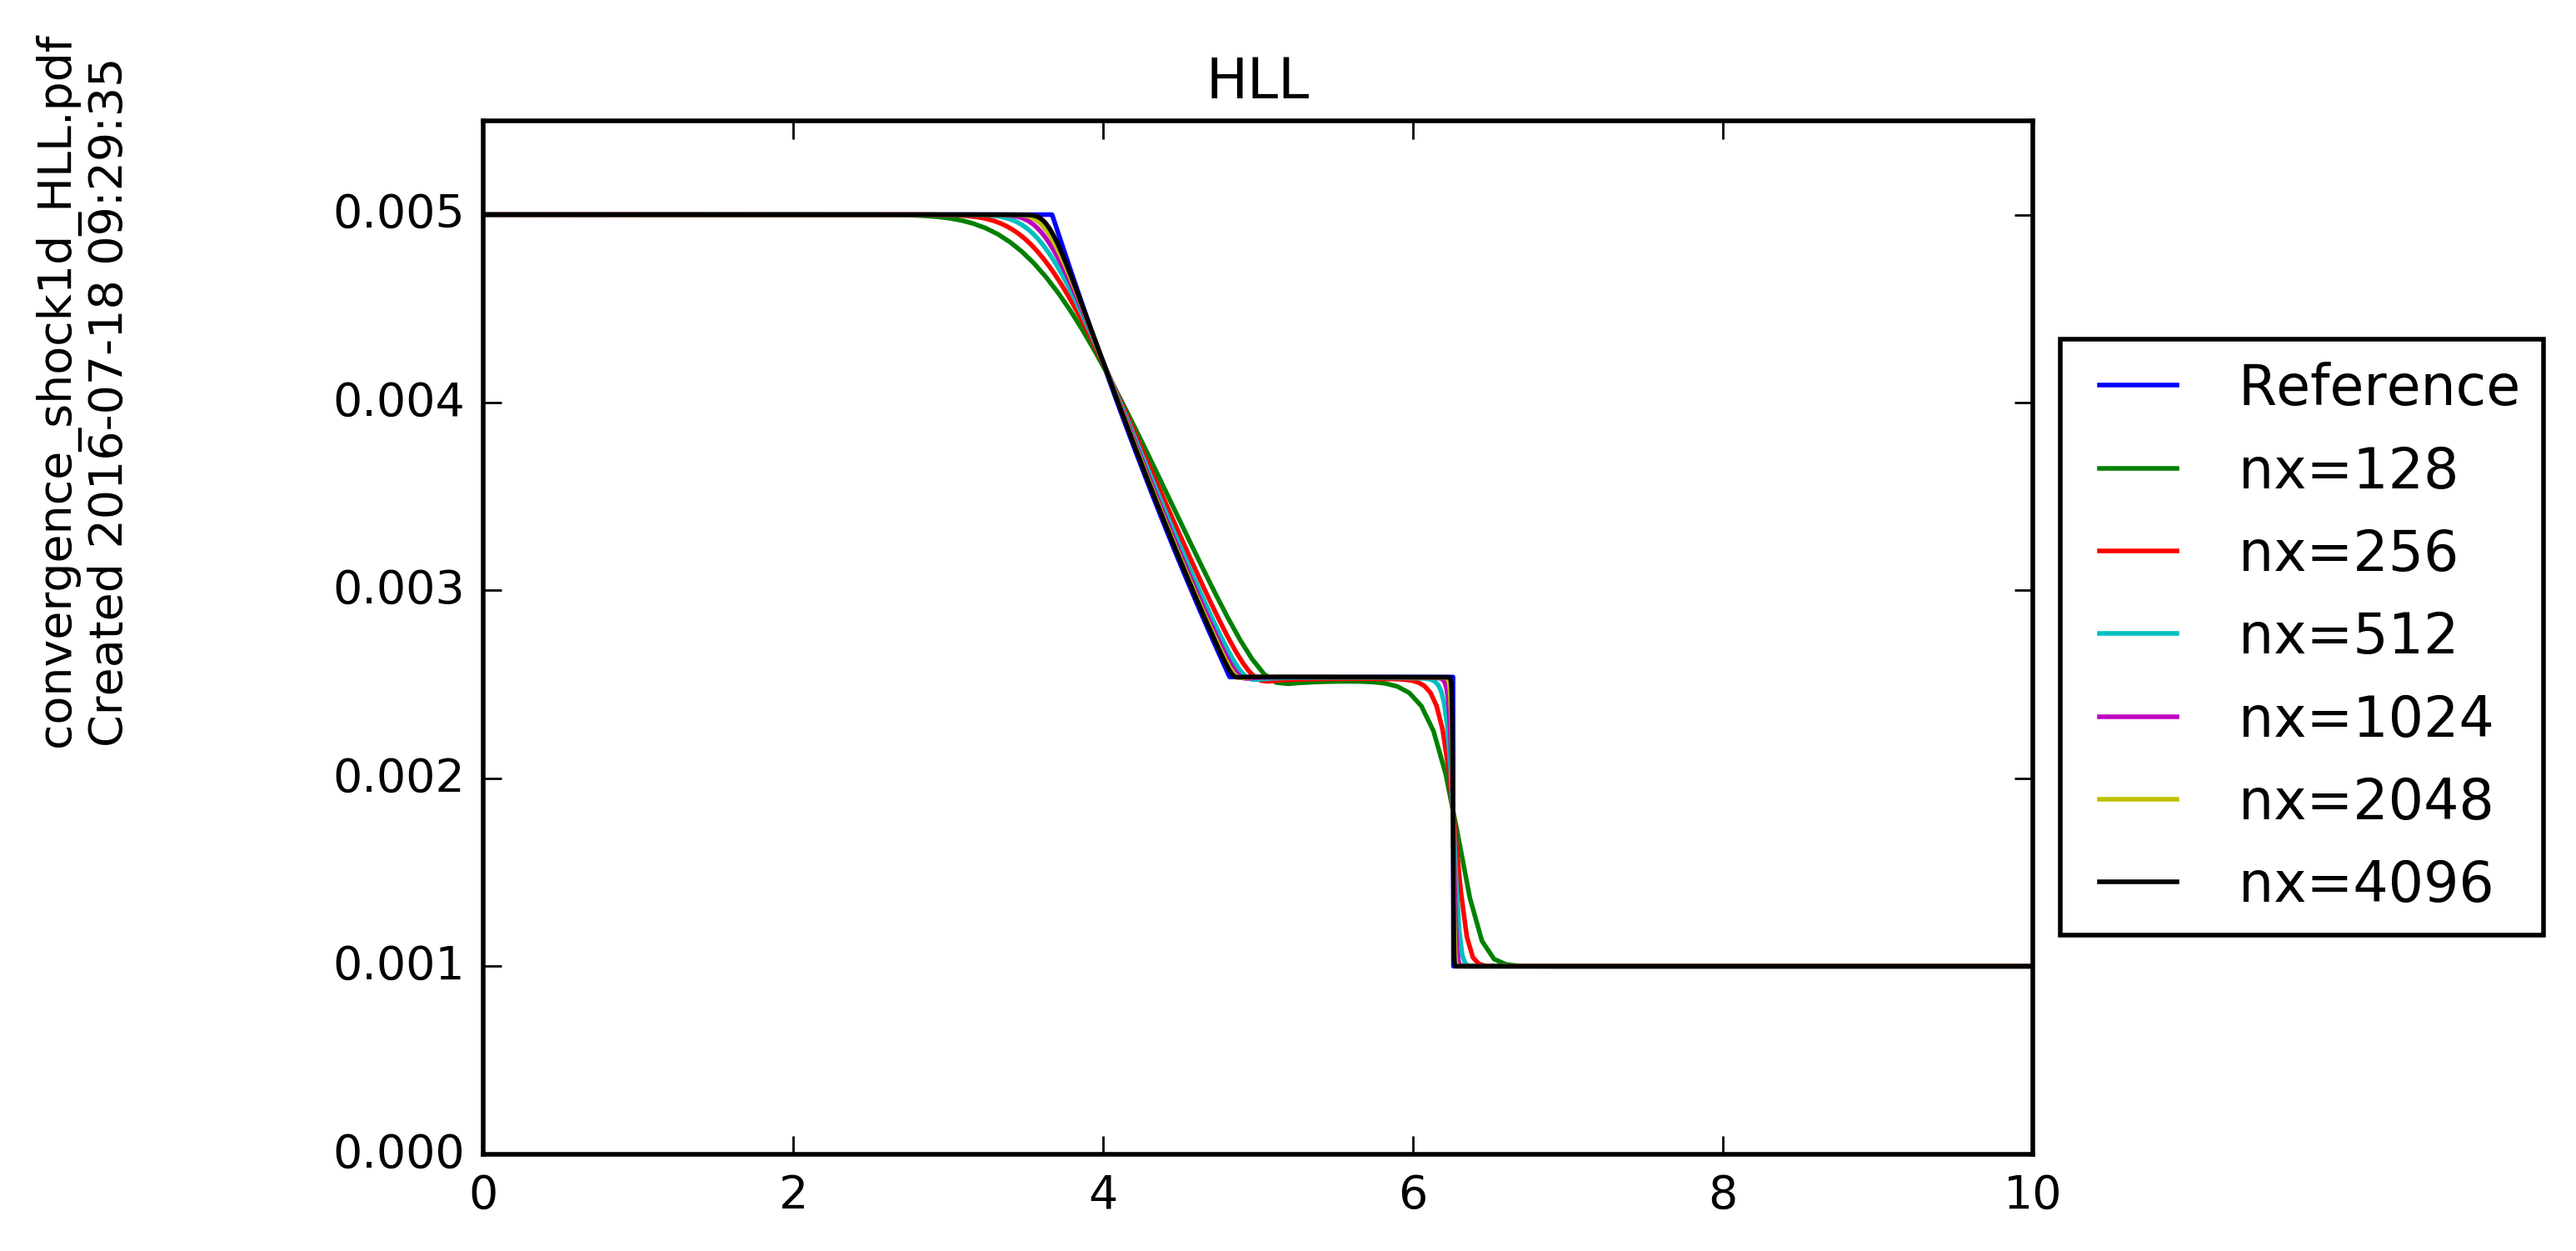

HLL2


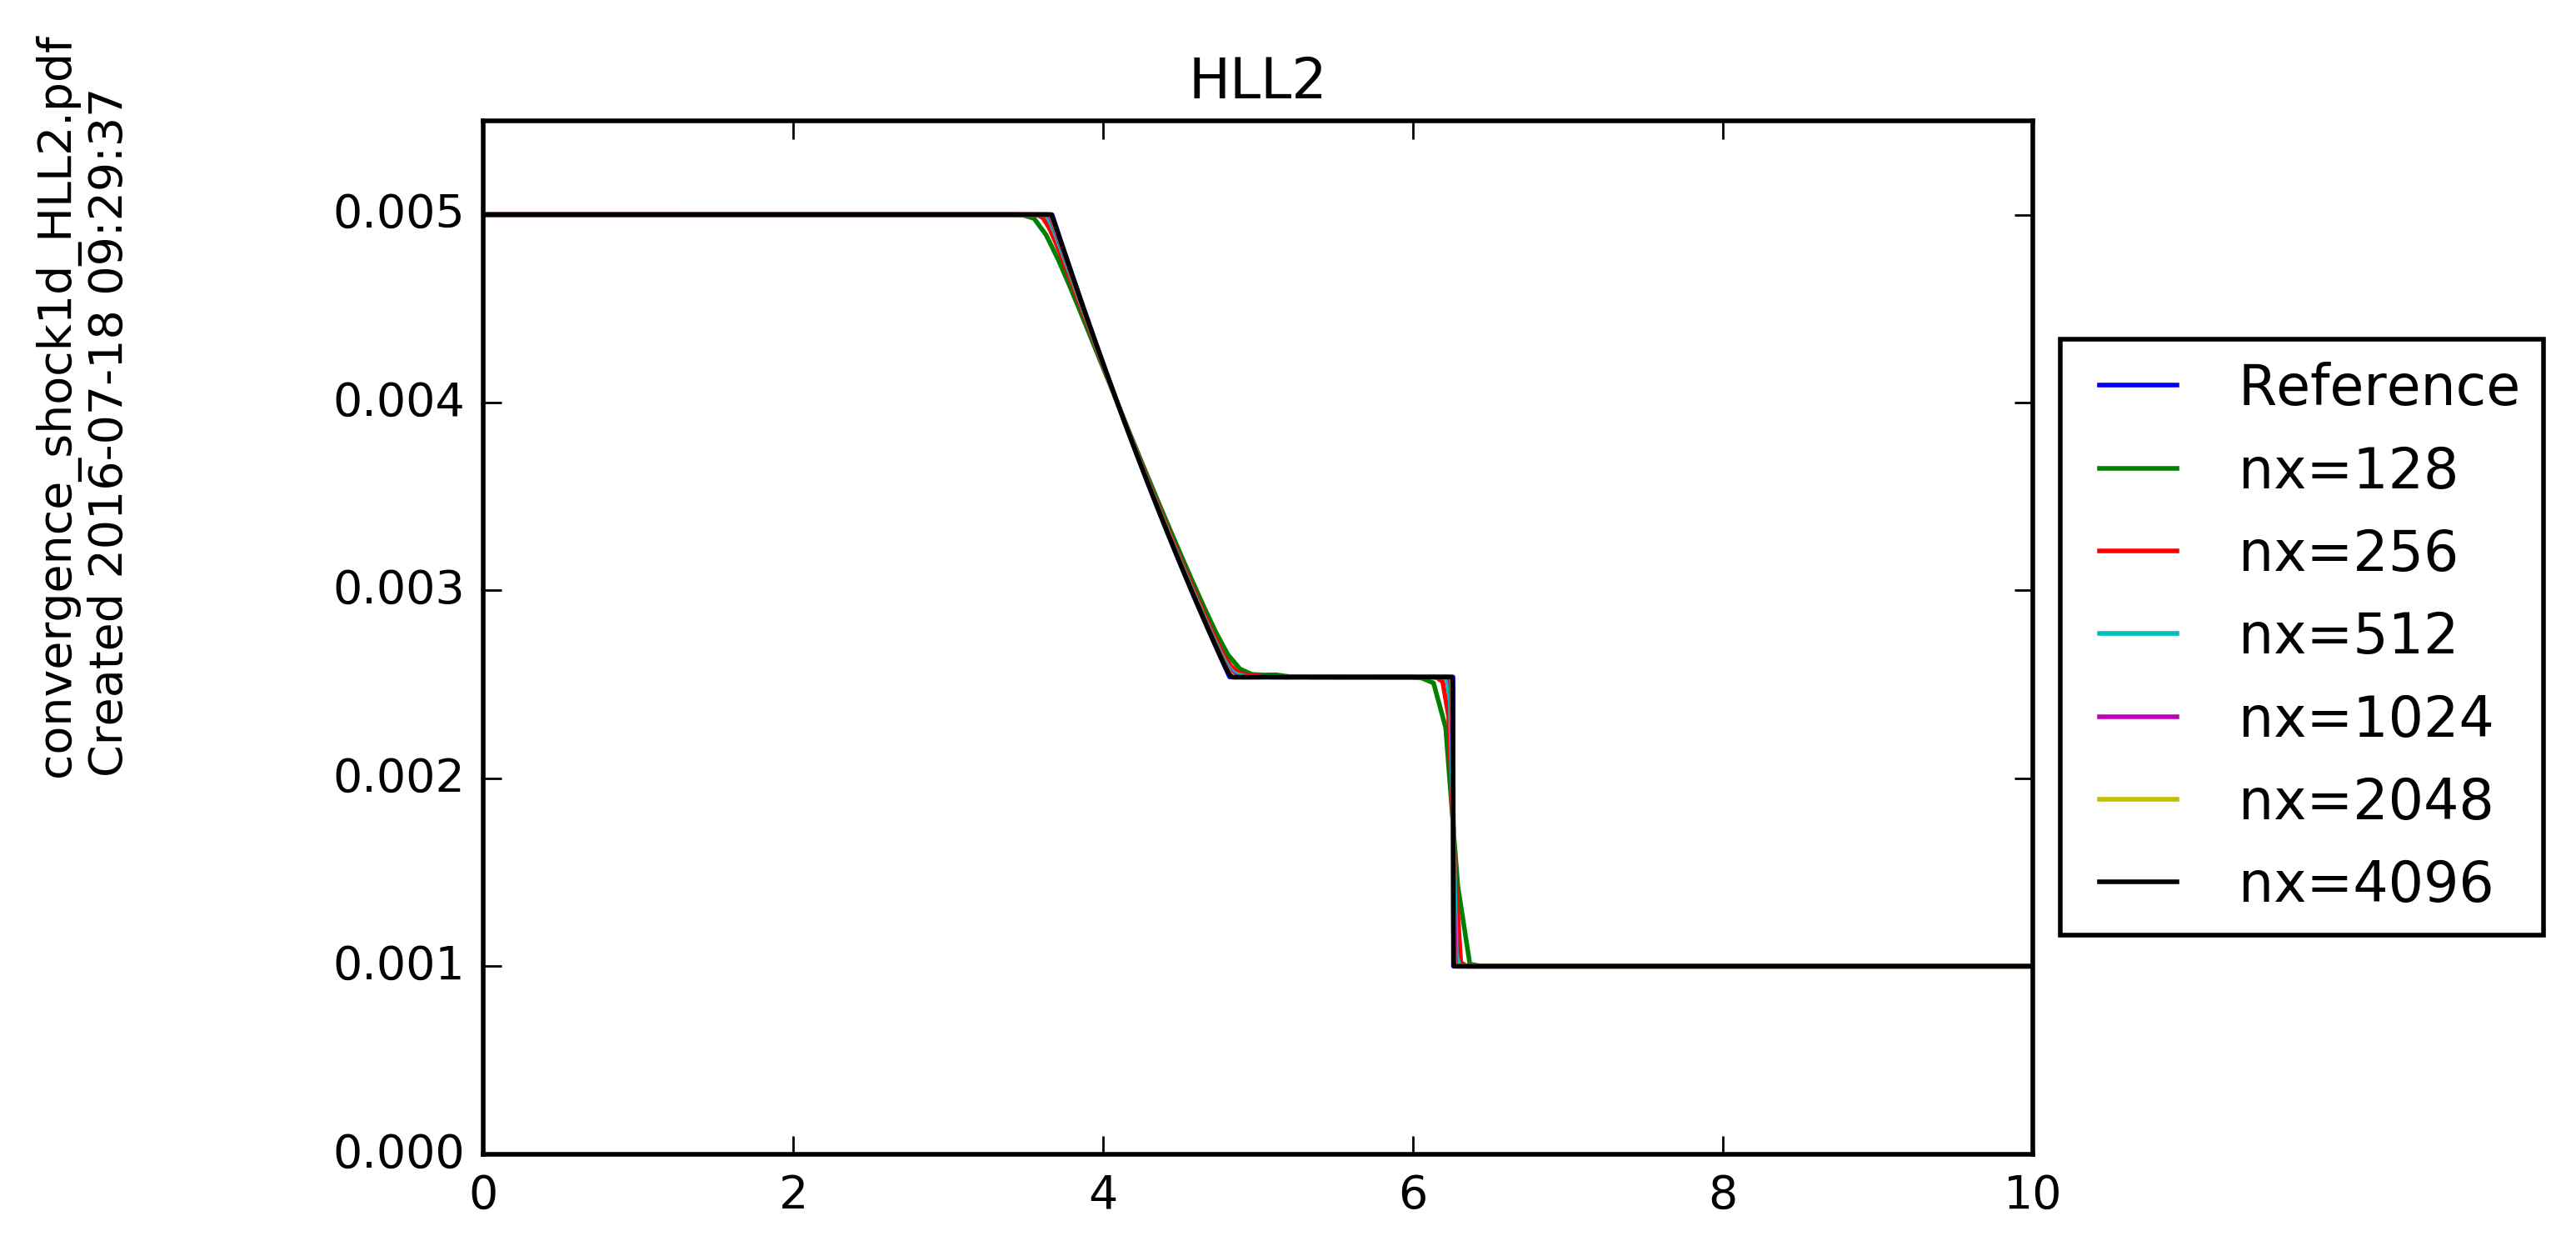

WAF


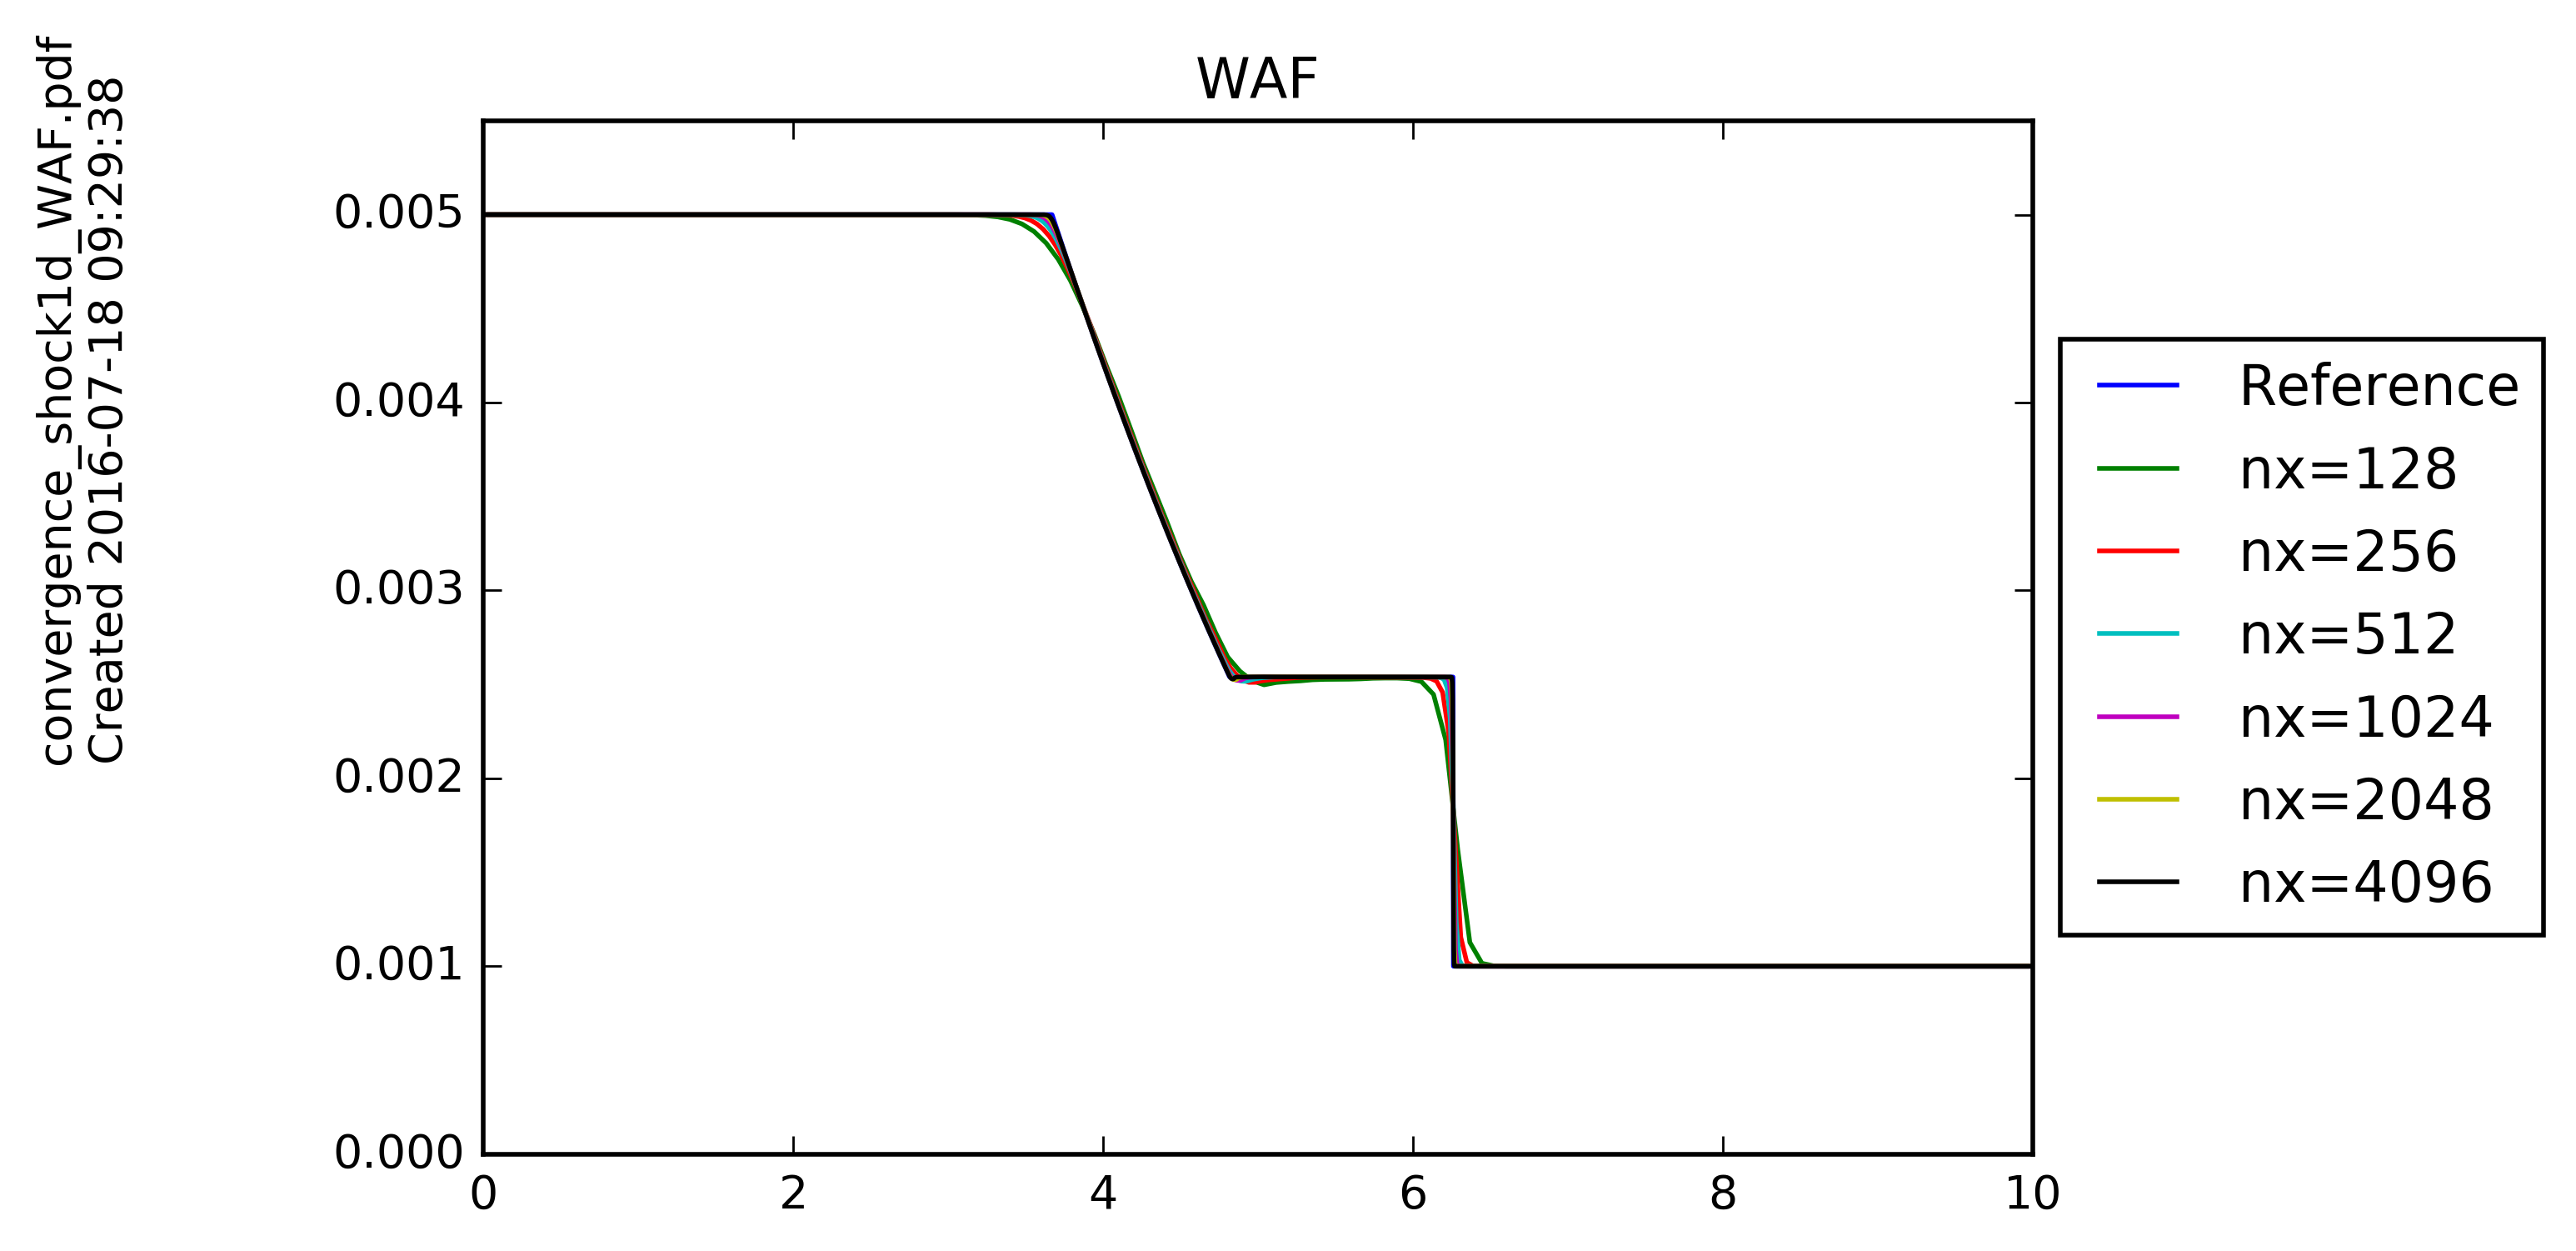

KP07


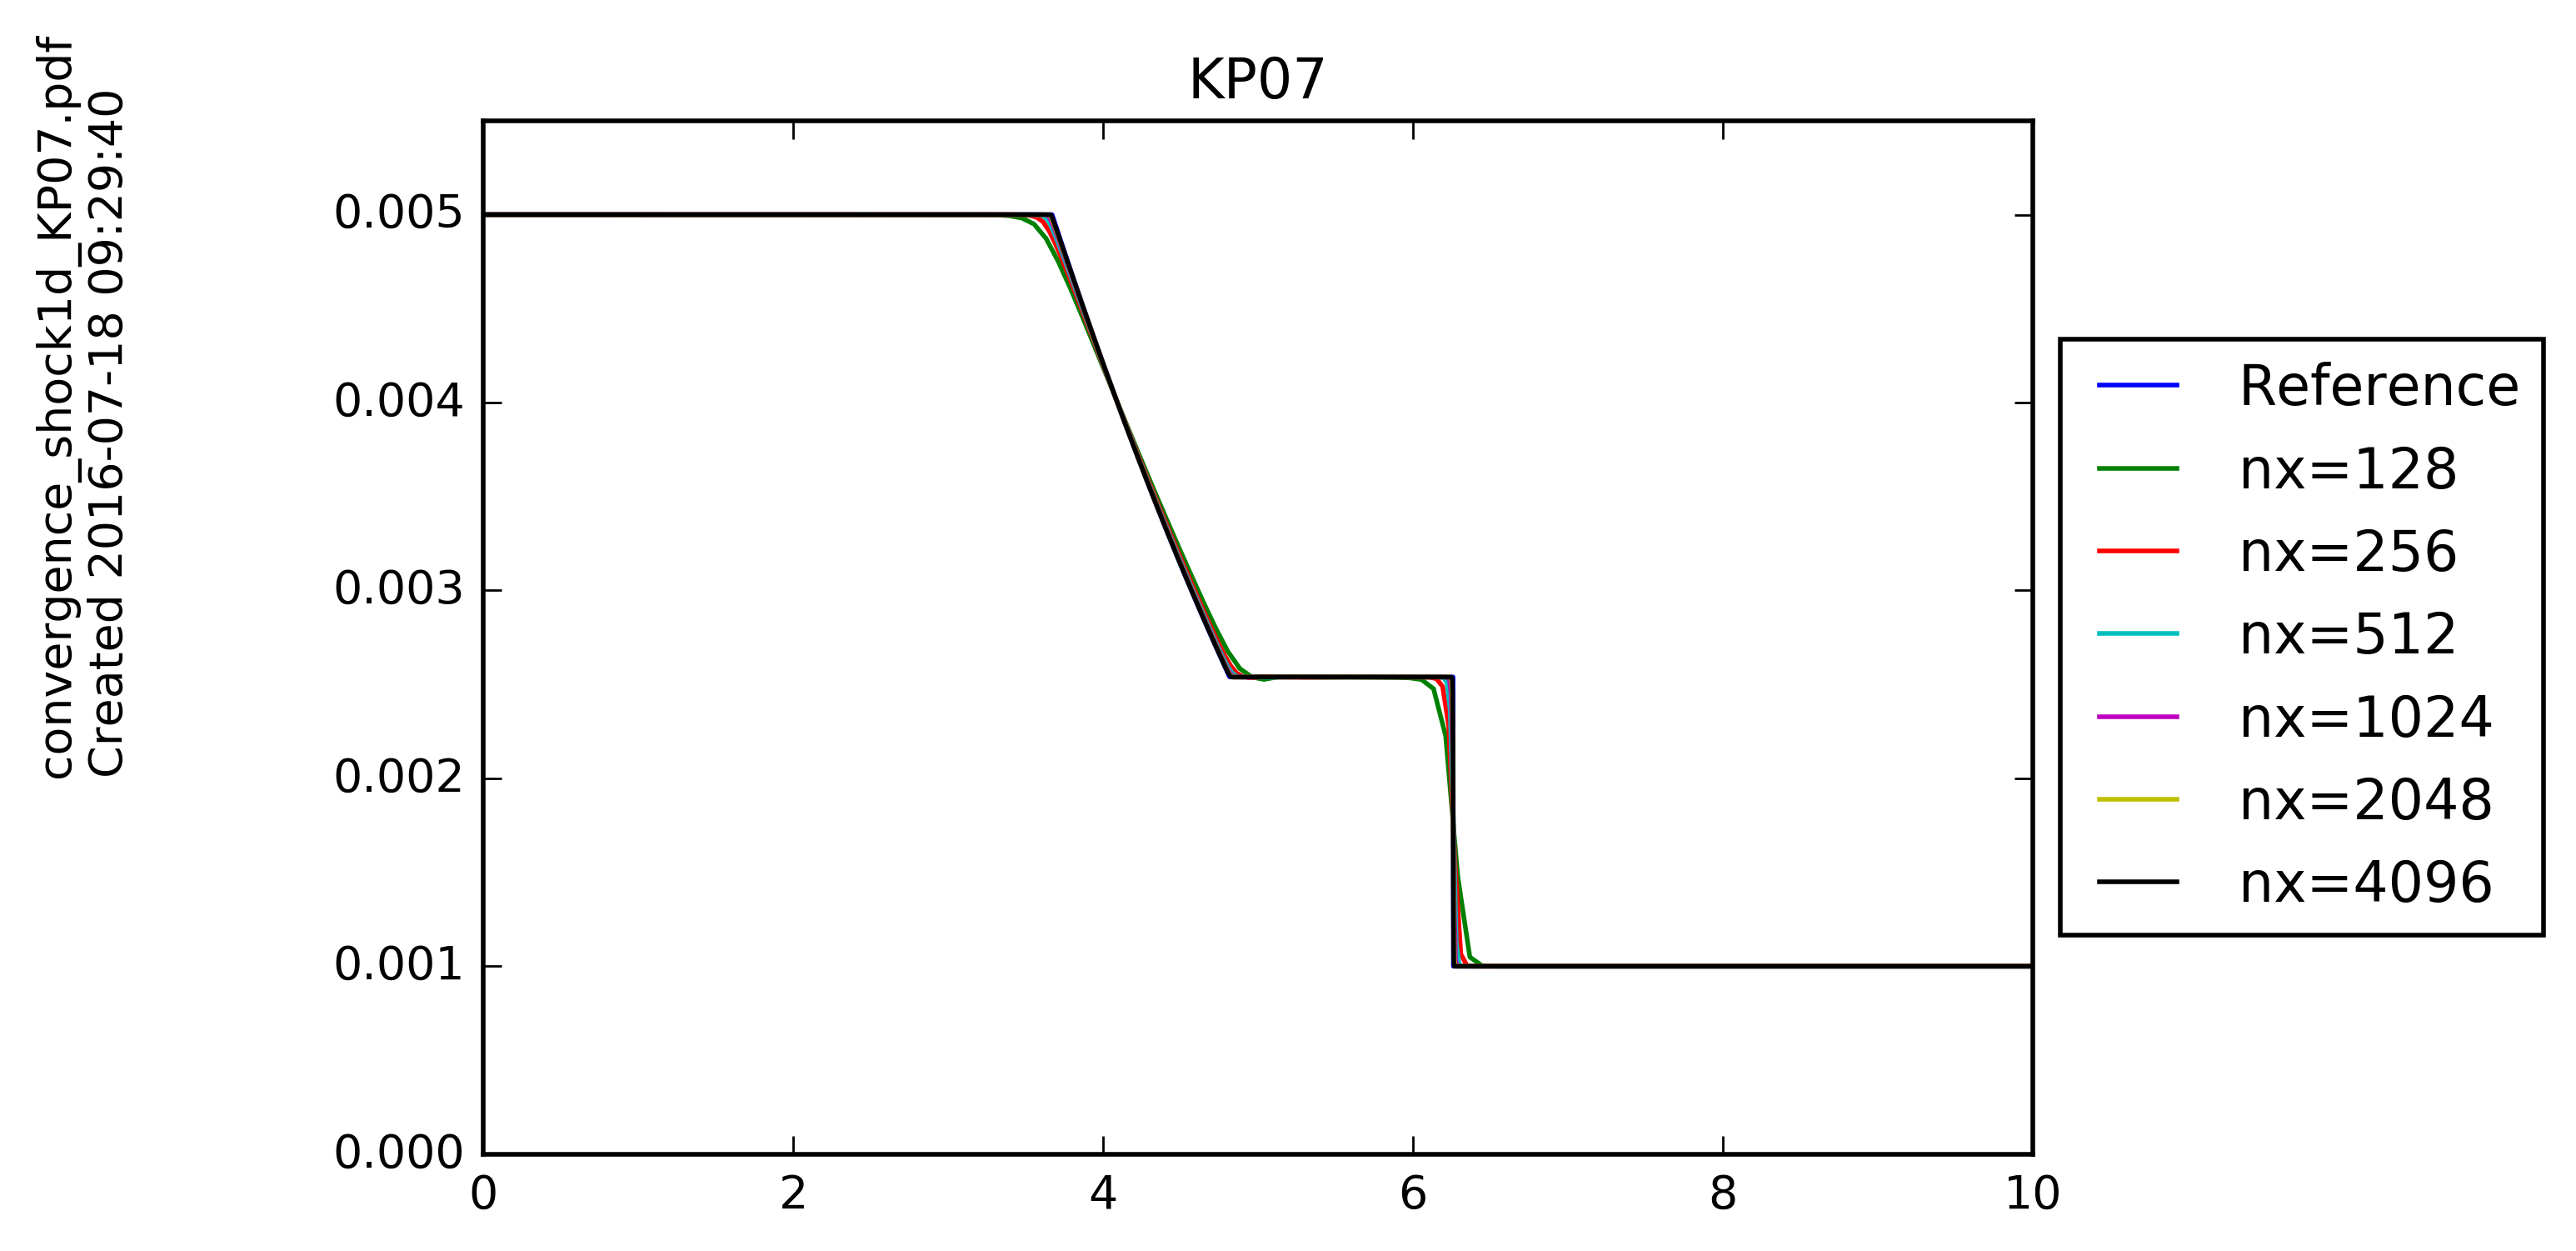

KP07 dimsplit


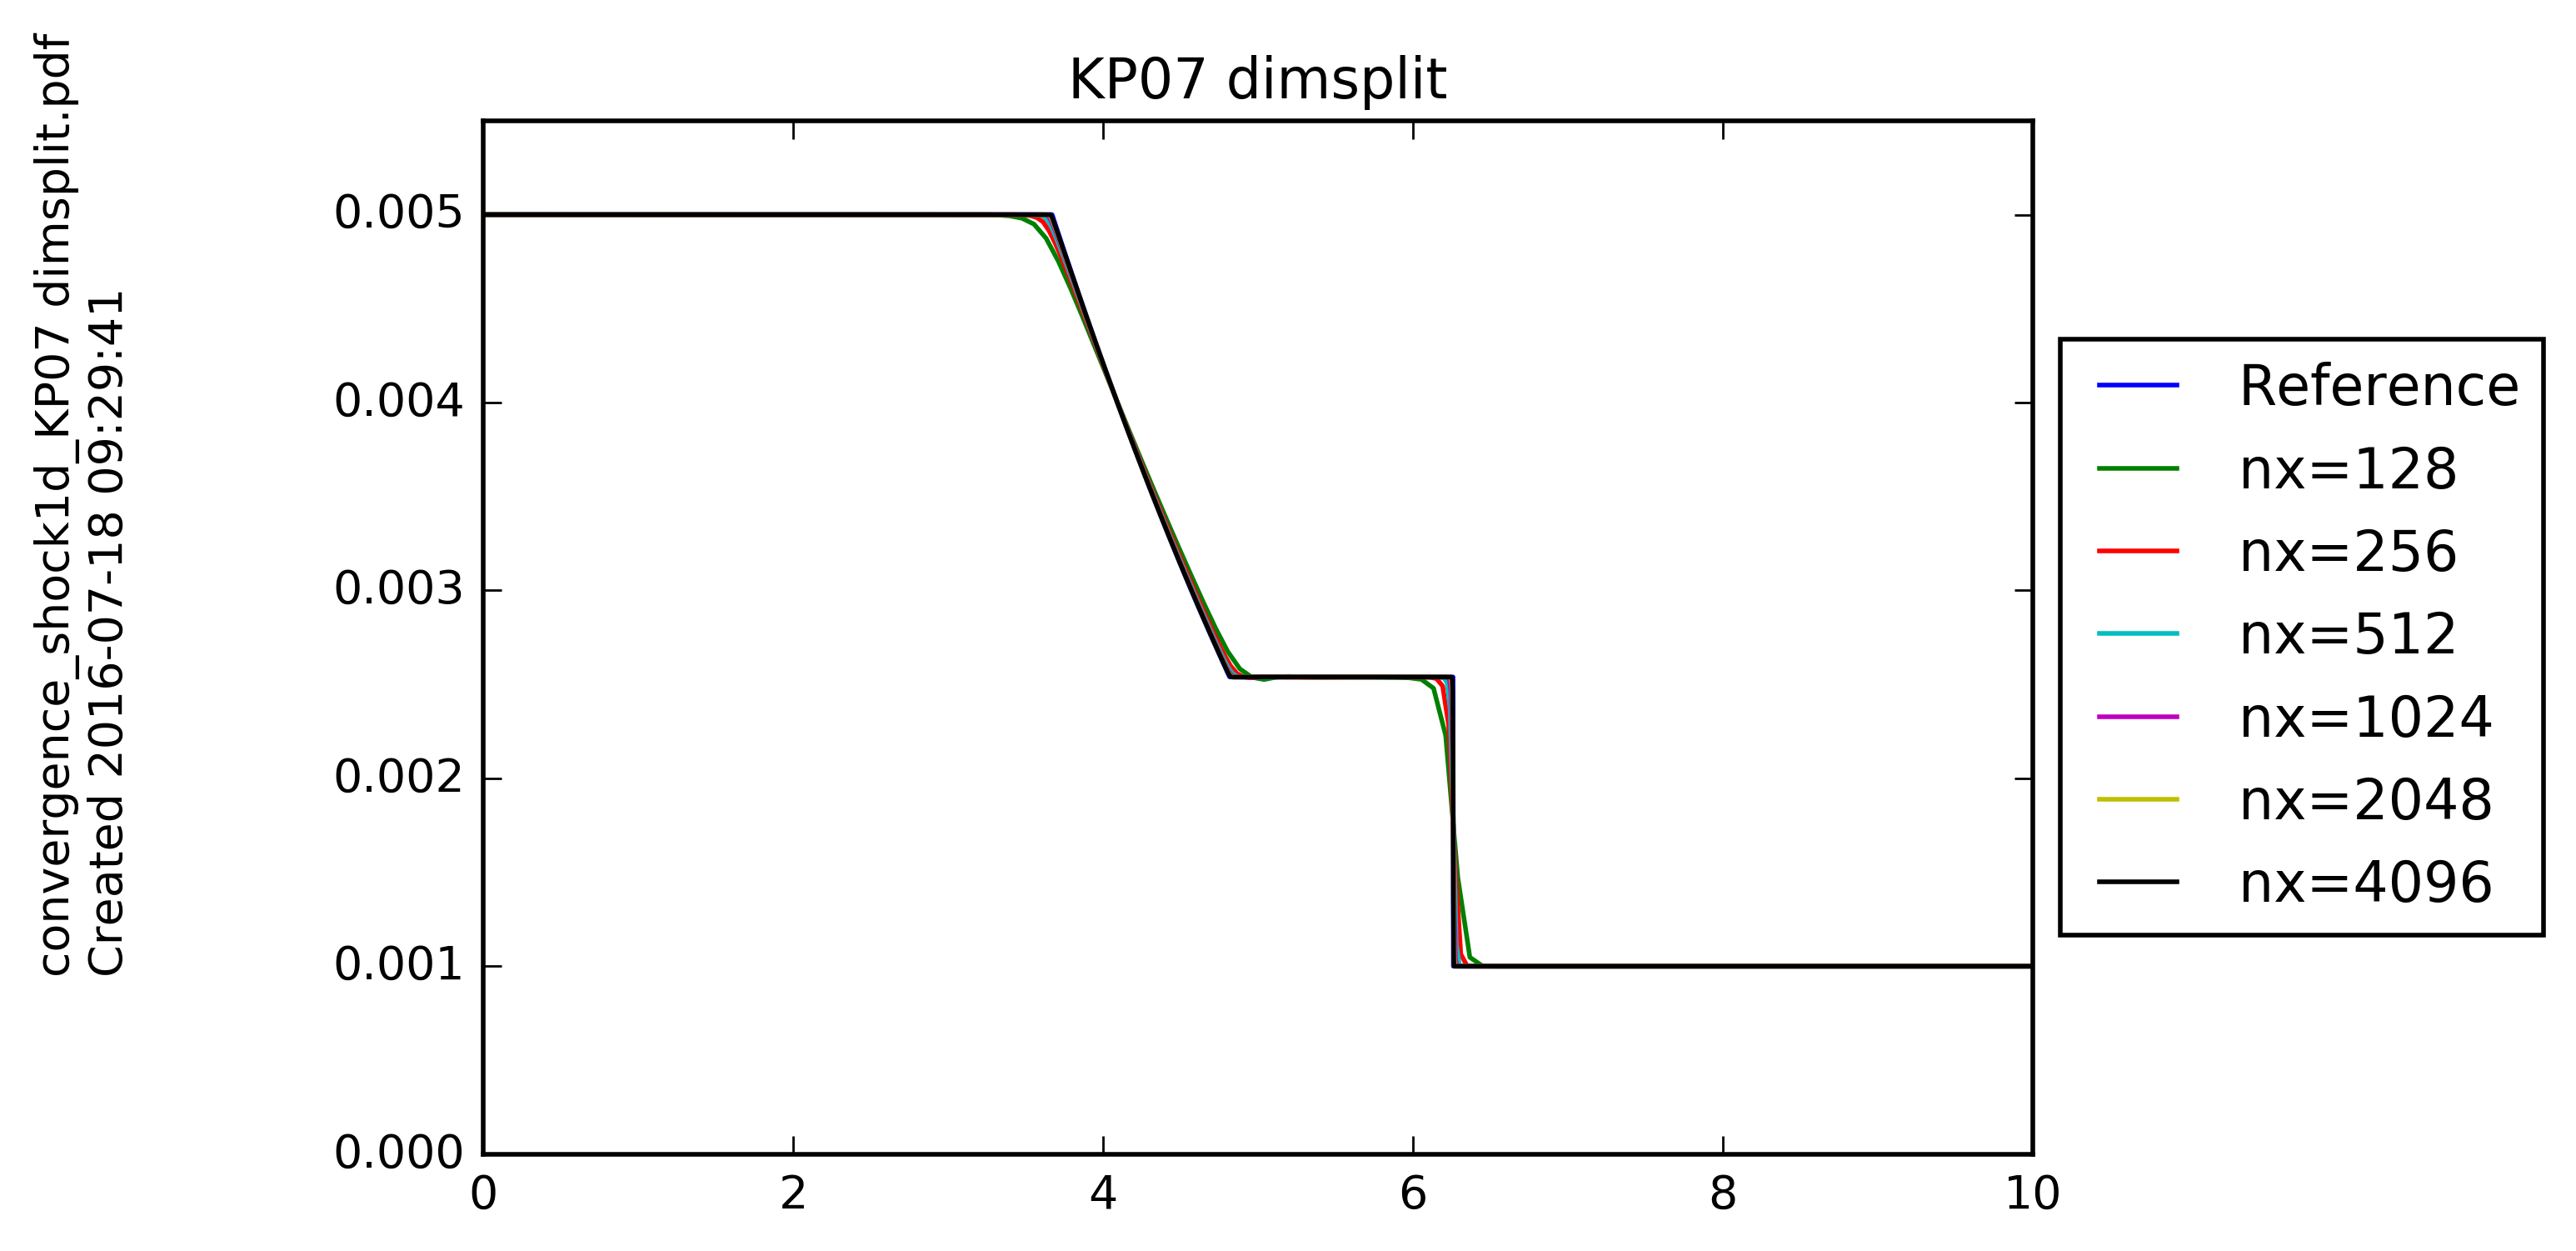

In [11]:
conservation = np.zeros((len(simulators), len(domain_sizes)))
error = np.zeros((len(simulators), len(domain_sizes)))

for i in range(len(simulators)):
    print simulator_names[i]
    ref_x, ref_h, _ = gen_reference(4096)
    
    fig = plt.figure()
    plt.plot(ref_x, ref_h, '-', label='Reference')
    
    gc.collect()
    
    for j, nx in enumerate(domain_sizes):
        x = np.linspace(0.5, nx-0.5, nx)*10.0/float(nx)
        h, _, _ = run_benchmark(simulators[i], \
                                nx, \
                                simulator_ghost_cells[i], \
                                courant_number=simulator_courant_numbers[i], \
                                dt_in=simulator_dt[i])
        gc.collect()
        
        plt.plot(x, h, '-', label='nx=' + str(nx))
        
        ref_x, ref_h, _ = gen_reference(nx)
        error[i, j] = np.linalg.norm(np.abs(ref_h - h), ord=1)/float(nx)
        conservation[i, j] = (np.sum(ref_h) - np.sum(h))
    plt.title(str(simulator_names[i]))
    plt.axis([0, 10, 0, 0.0055])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    save_figure(fig, simulator_names[i])
    plt.show()

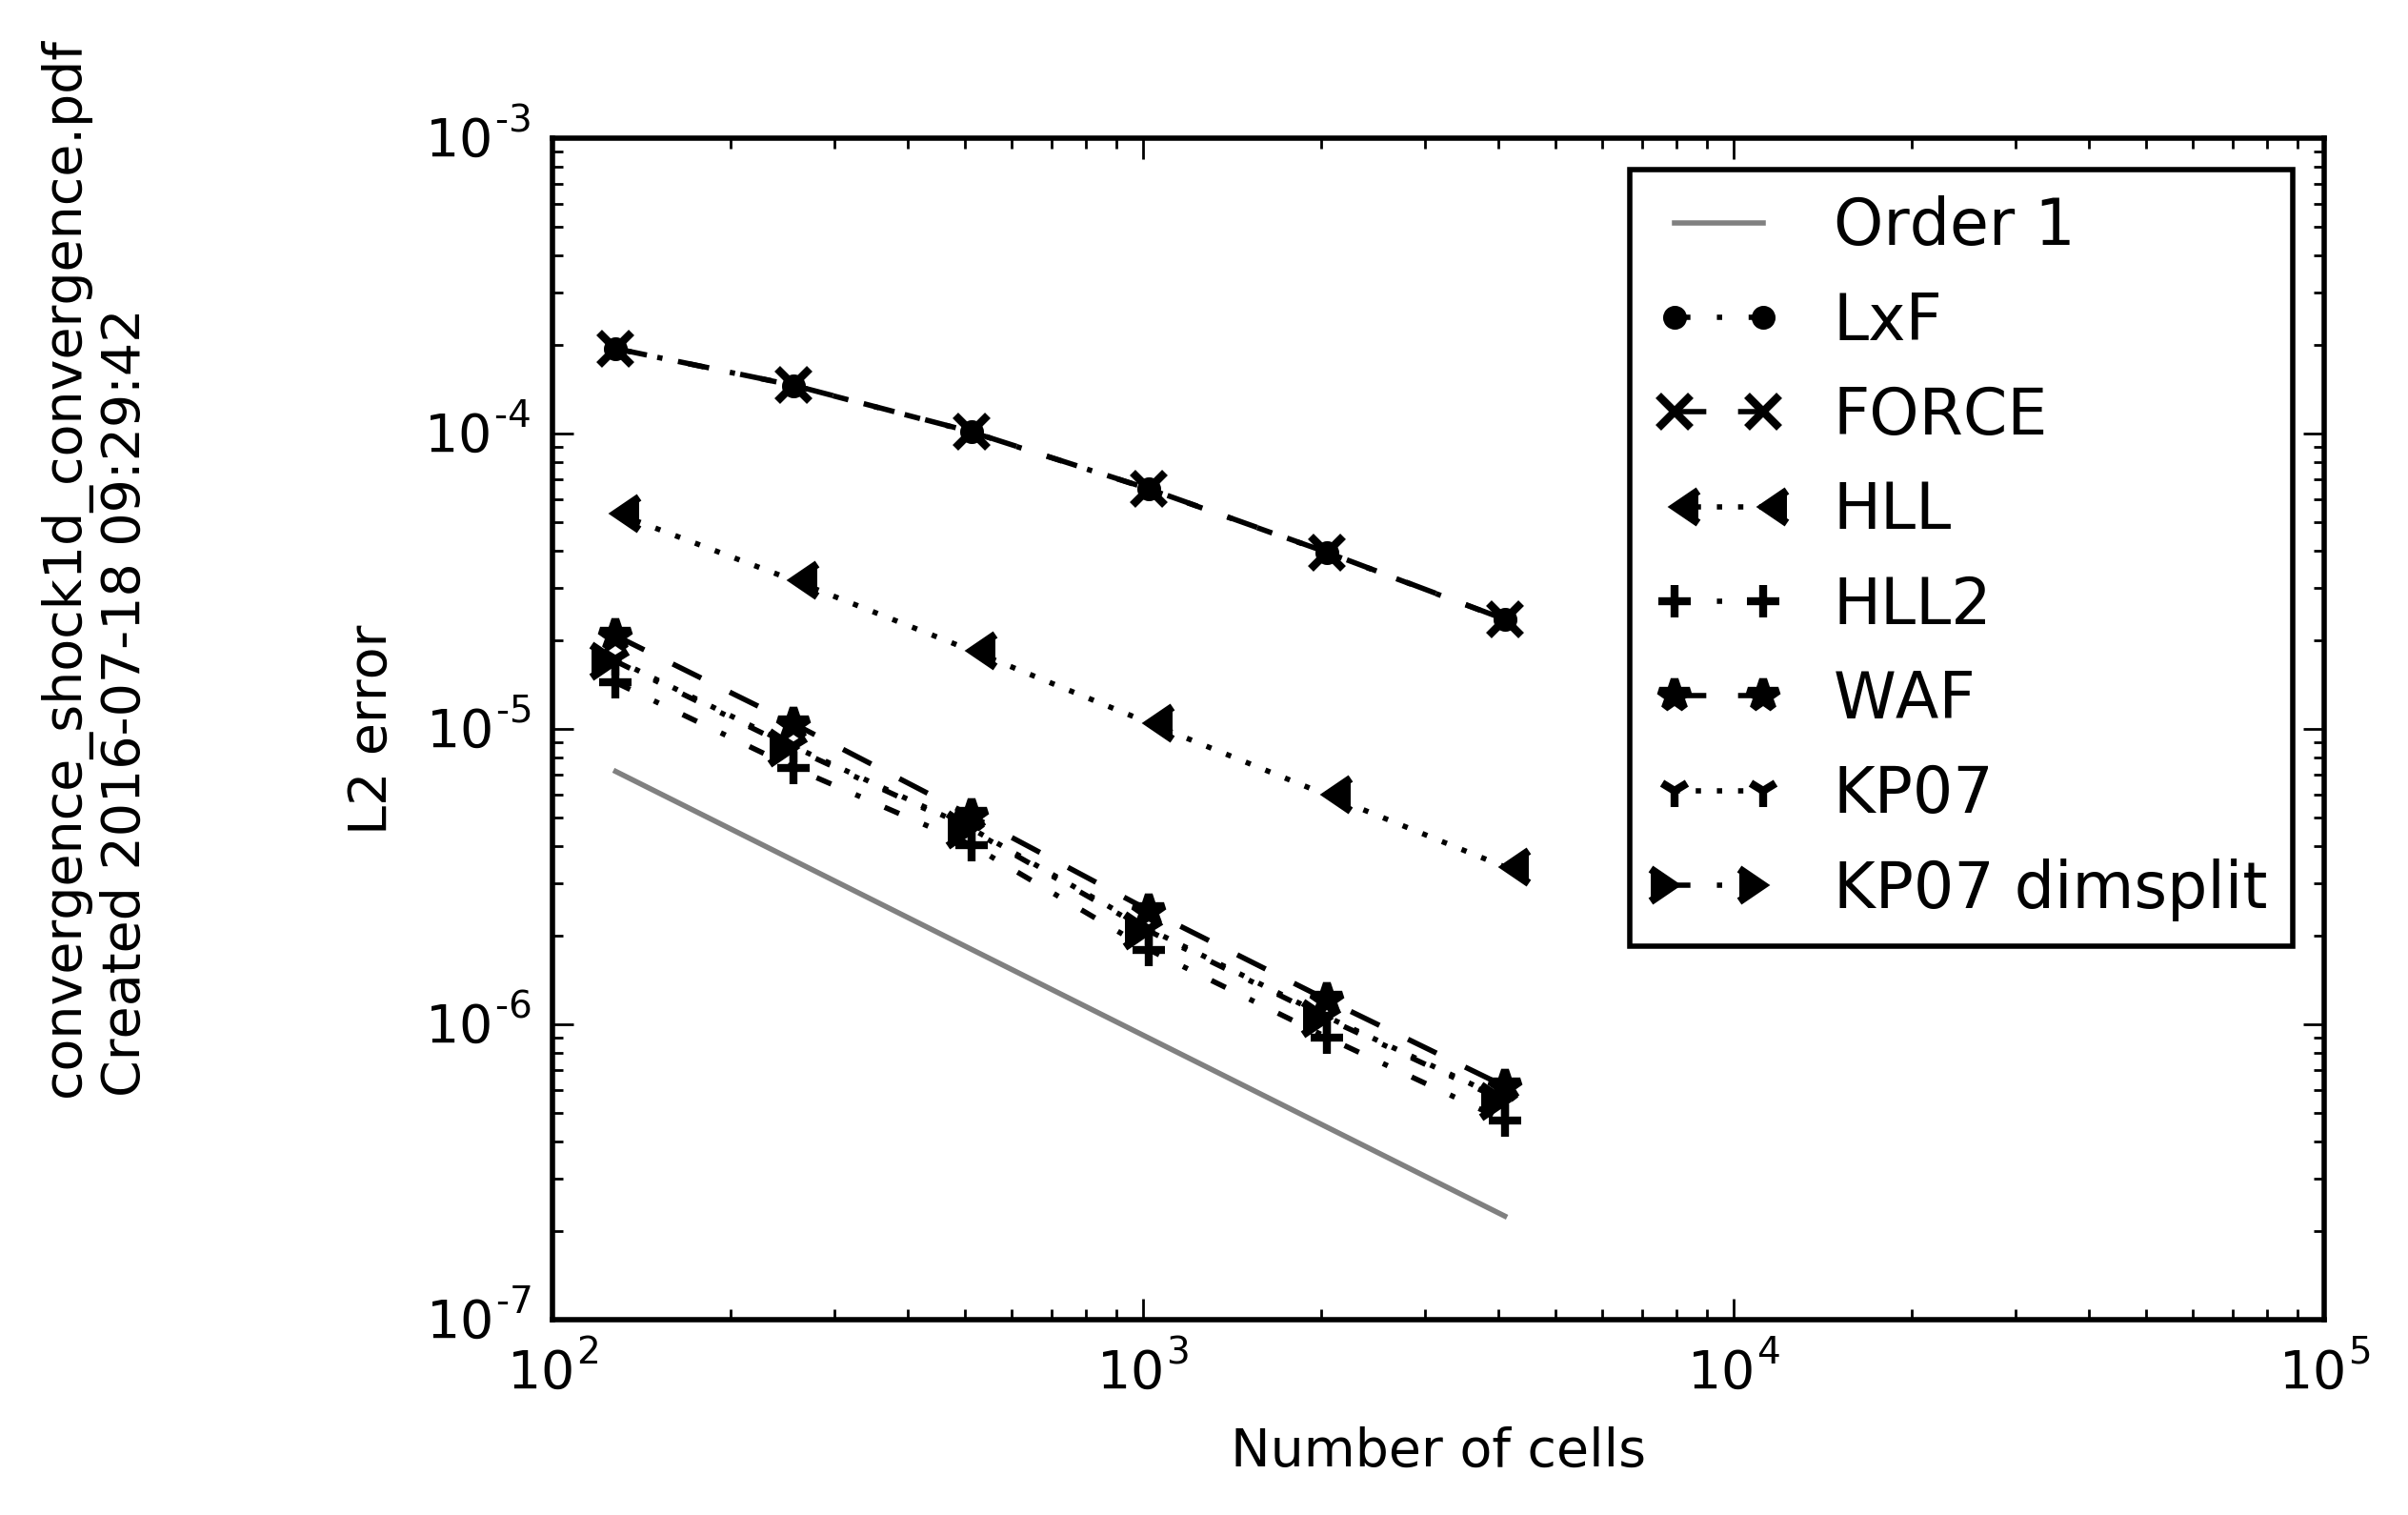

In [12]:
fig = plt.figure()
setBwStyles(fig.gca())

x = np.linspace(domain_sizes[0], domain_sizes[-1], 100);

#scaling = np.min(error[:,0]) * domain_sizes[0]**0.5 * 0.5
#plt.loglog(x, scaling/(np.sqrt(x)), '-', color='gray', label='Order 0.5')

scaling = np.min(error[:,0]) * domain_sizes[0] * 0.5
plt.loglog(x, scaling/x, '-', color='gray', label='Order 1')

#scaling = np.min(error[:,0]) * domain_sizes[0]**2 * 0.5
#plt.loglog(x, scaling/(x*x), '-', color='gray', label='Order 2')

for i in range(len(simulators)):
    plt.loglog(domain_sizes, error[i,:], label=simulator_names[i])
    
plt.xlabel('Number of cells')
plt.ylabel('L2 error')
plt.axis([10**2, 10**5, 10**-7, 10**-3])
plt.legend()
save_figure(fig, "convergence")

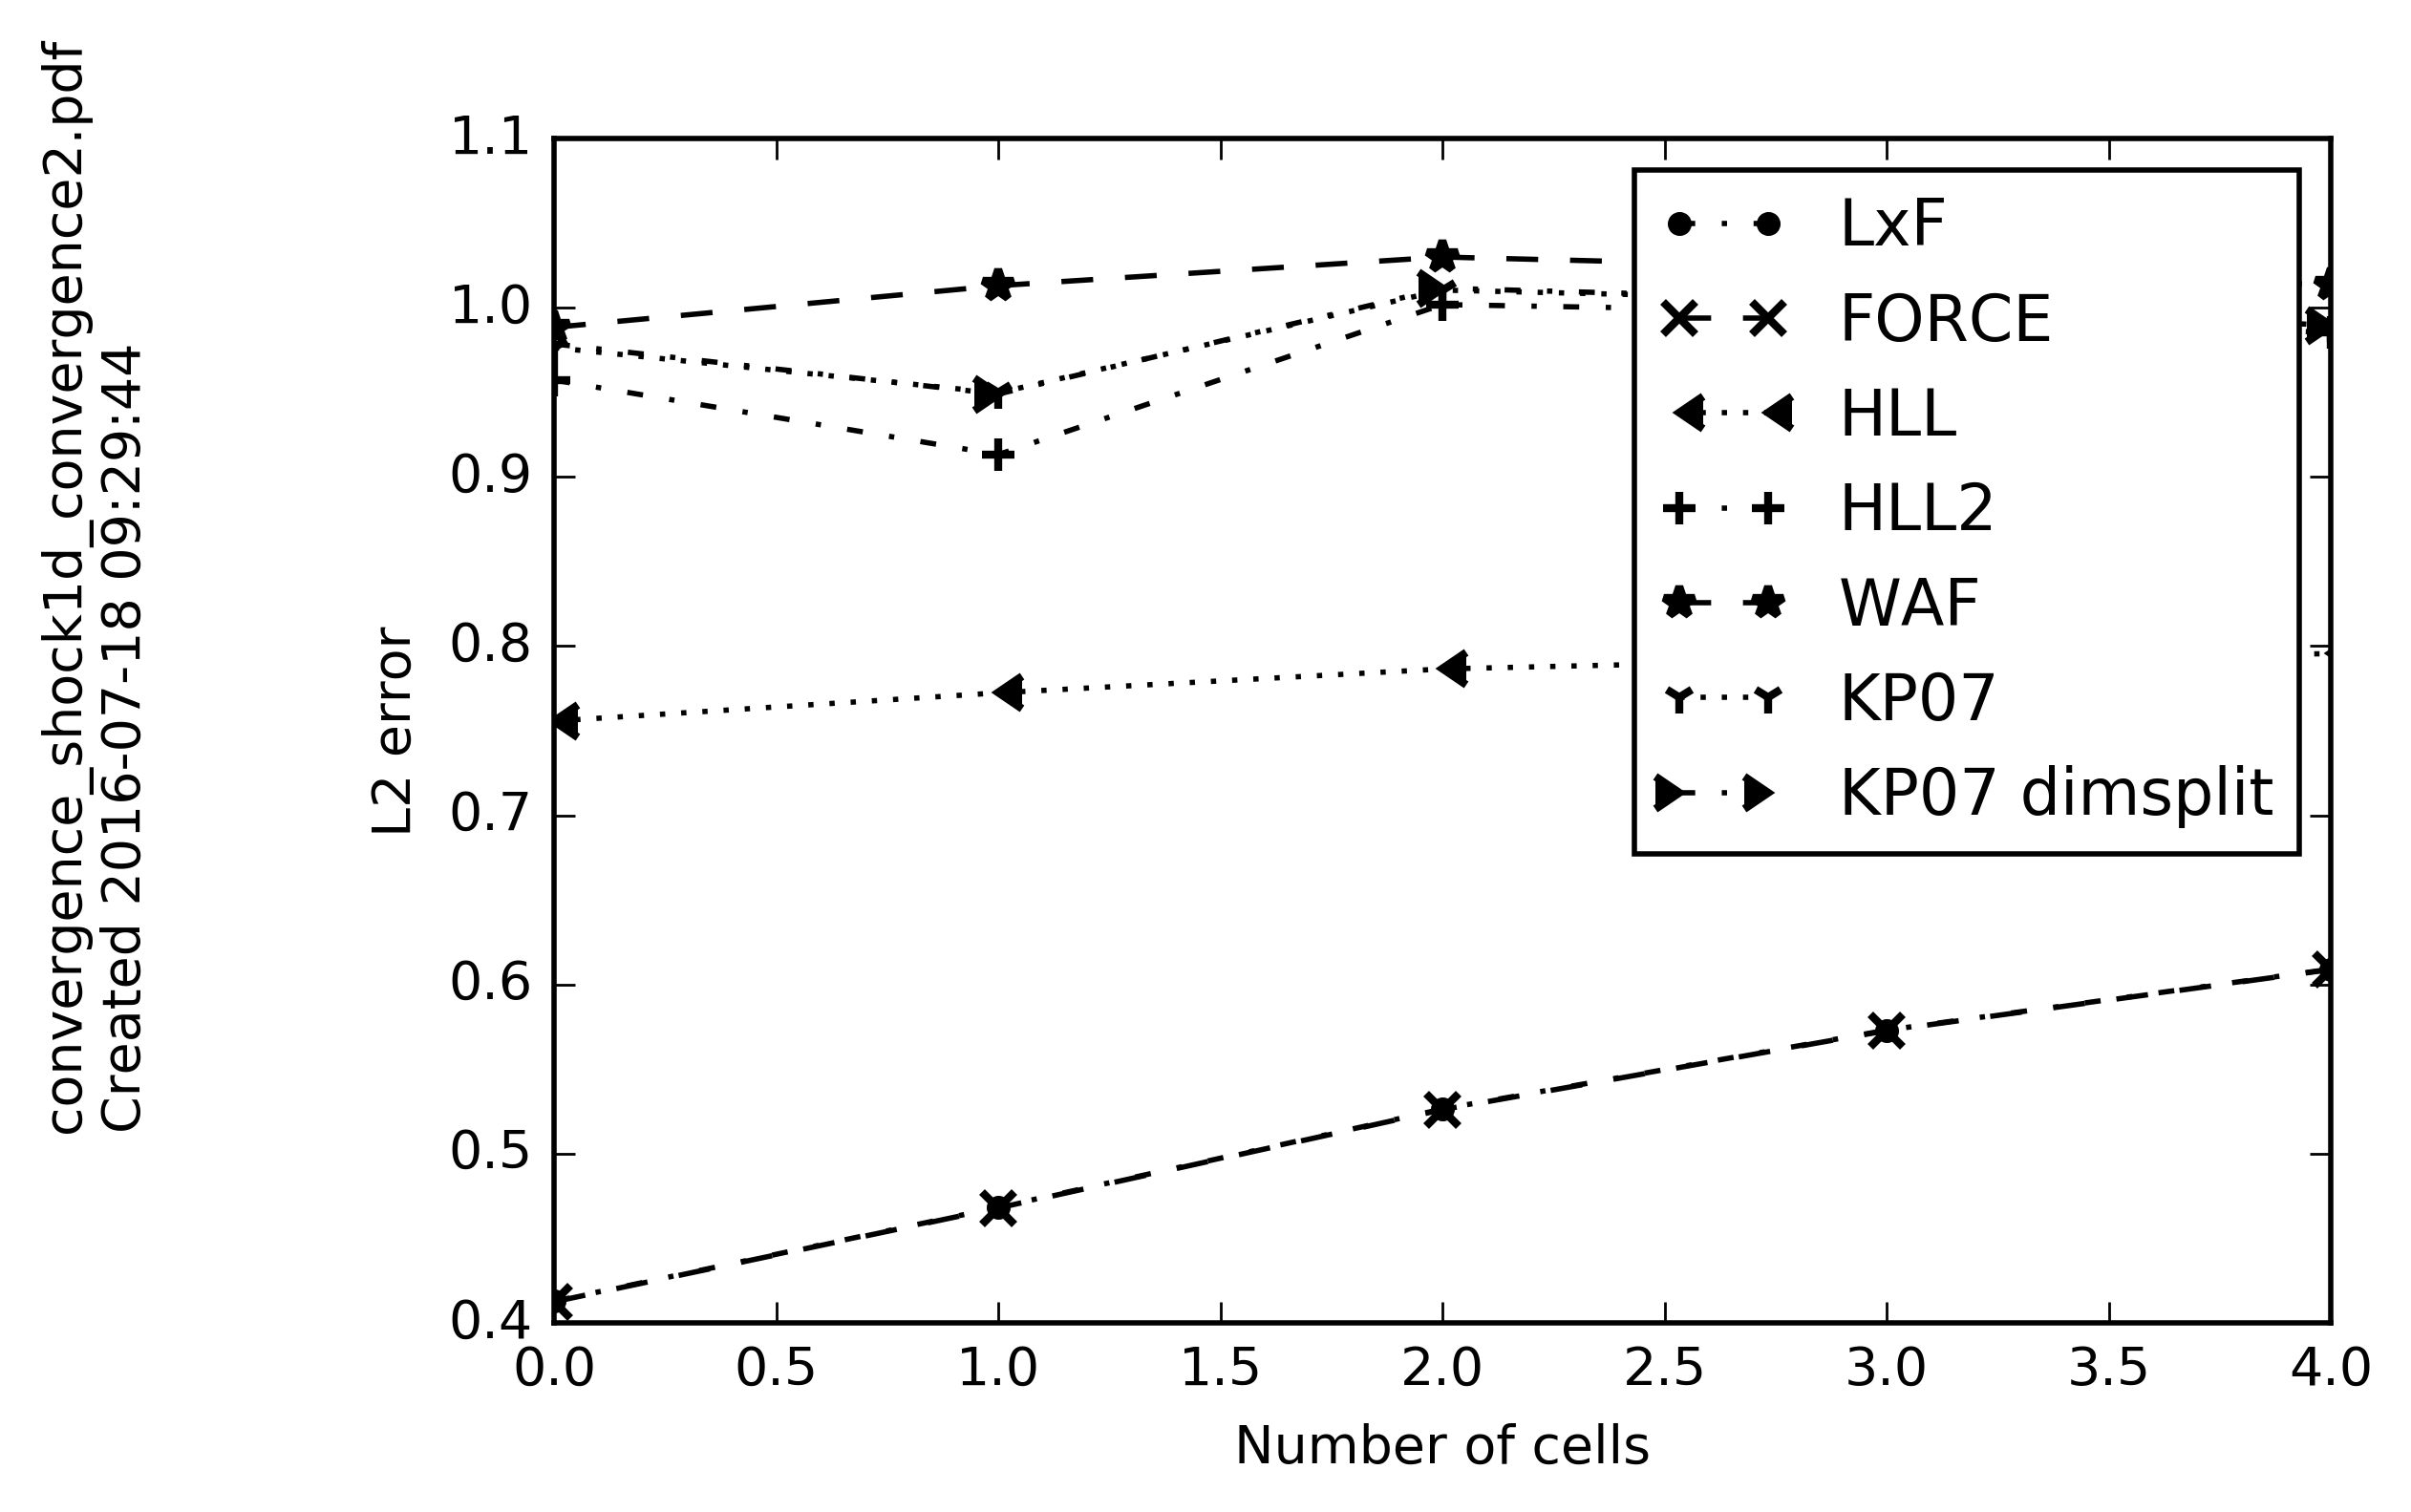

In [13]:
fig = plt.figure()
setBwStyles(fig.gca())

for i in range(len(simulators)):
    a = np.arange(1, len(domain_sizes))
    #order = np.log2(error[i, :-1] / error[i, 1:])
    order = np.log2(error[i, 0] / (error[i, 1:]) )/a
    plt.plot(order, label=simulator_names[i])
    
plt.xlabel('Number of cells')
plt.ylabel('L2 error')
plt.legend()
save_figure(fig, "convergence2")

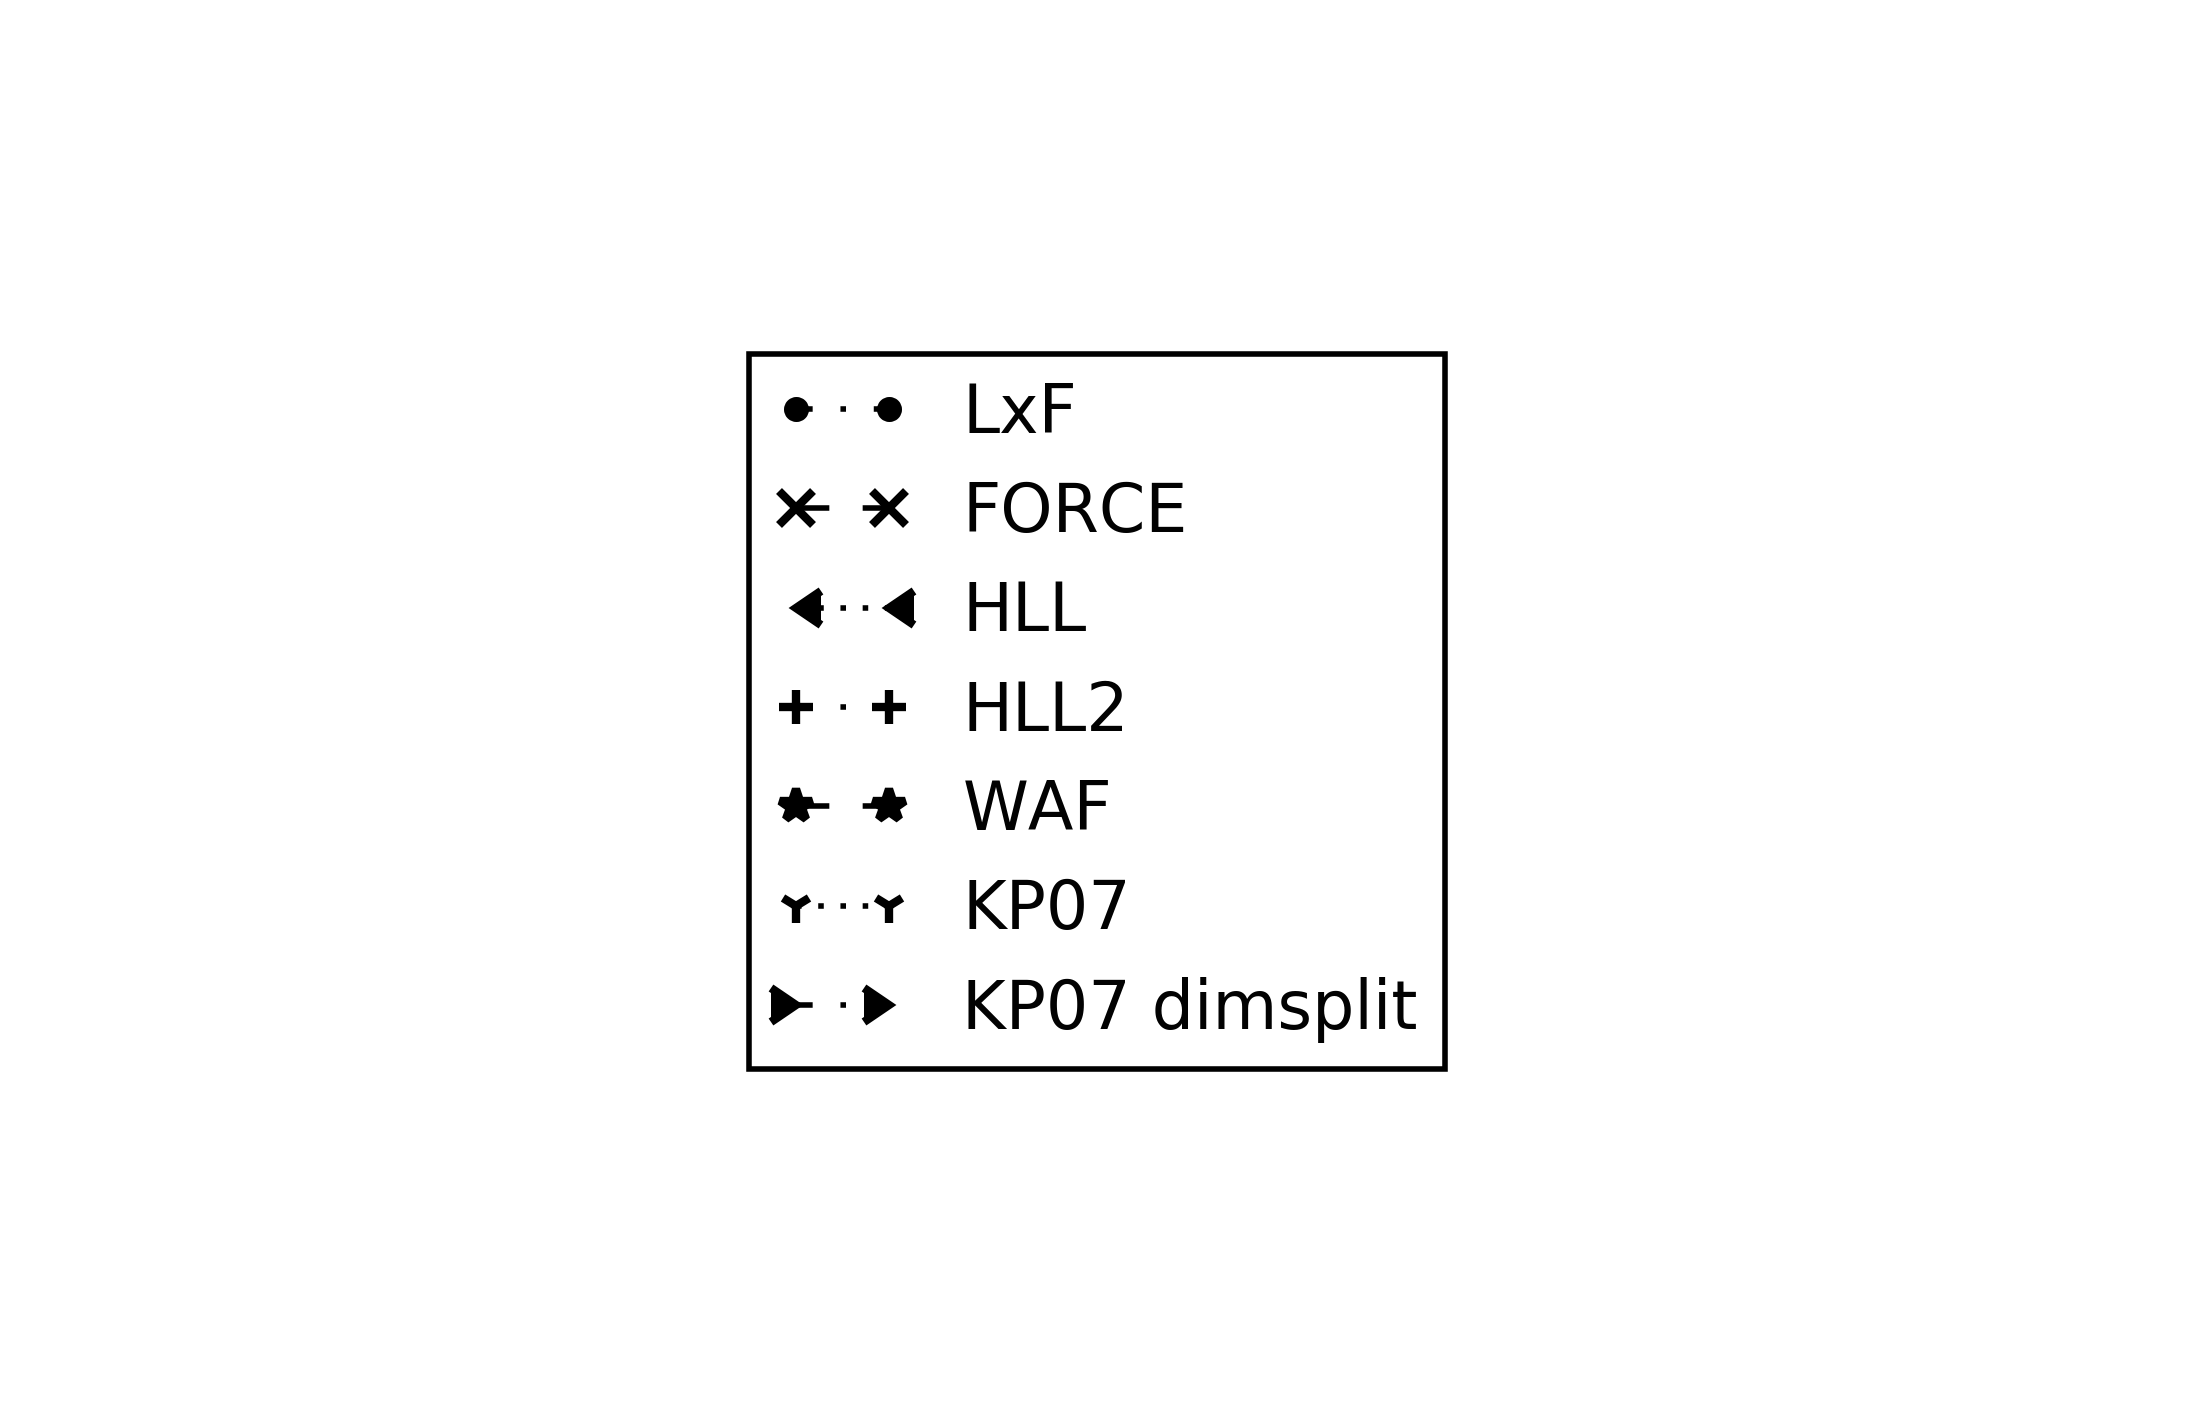

In [14]:
figLegend = plt.figure()#figsize = (1.5,1.3))
plt.plot(0, 0)
plt.figlegend(*fig.gca().get_legend_handles_labels(), loc = 'center')
plt.axis('off')
plt.show()

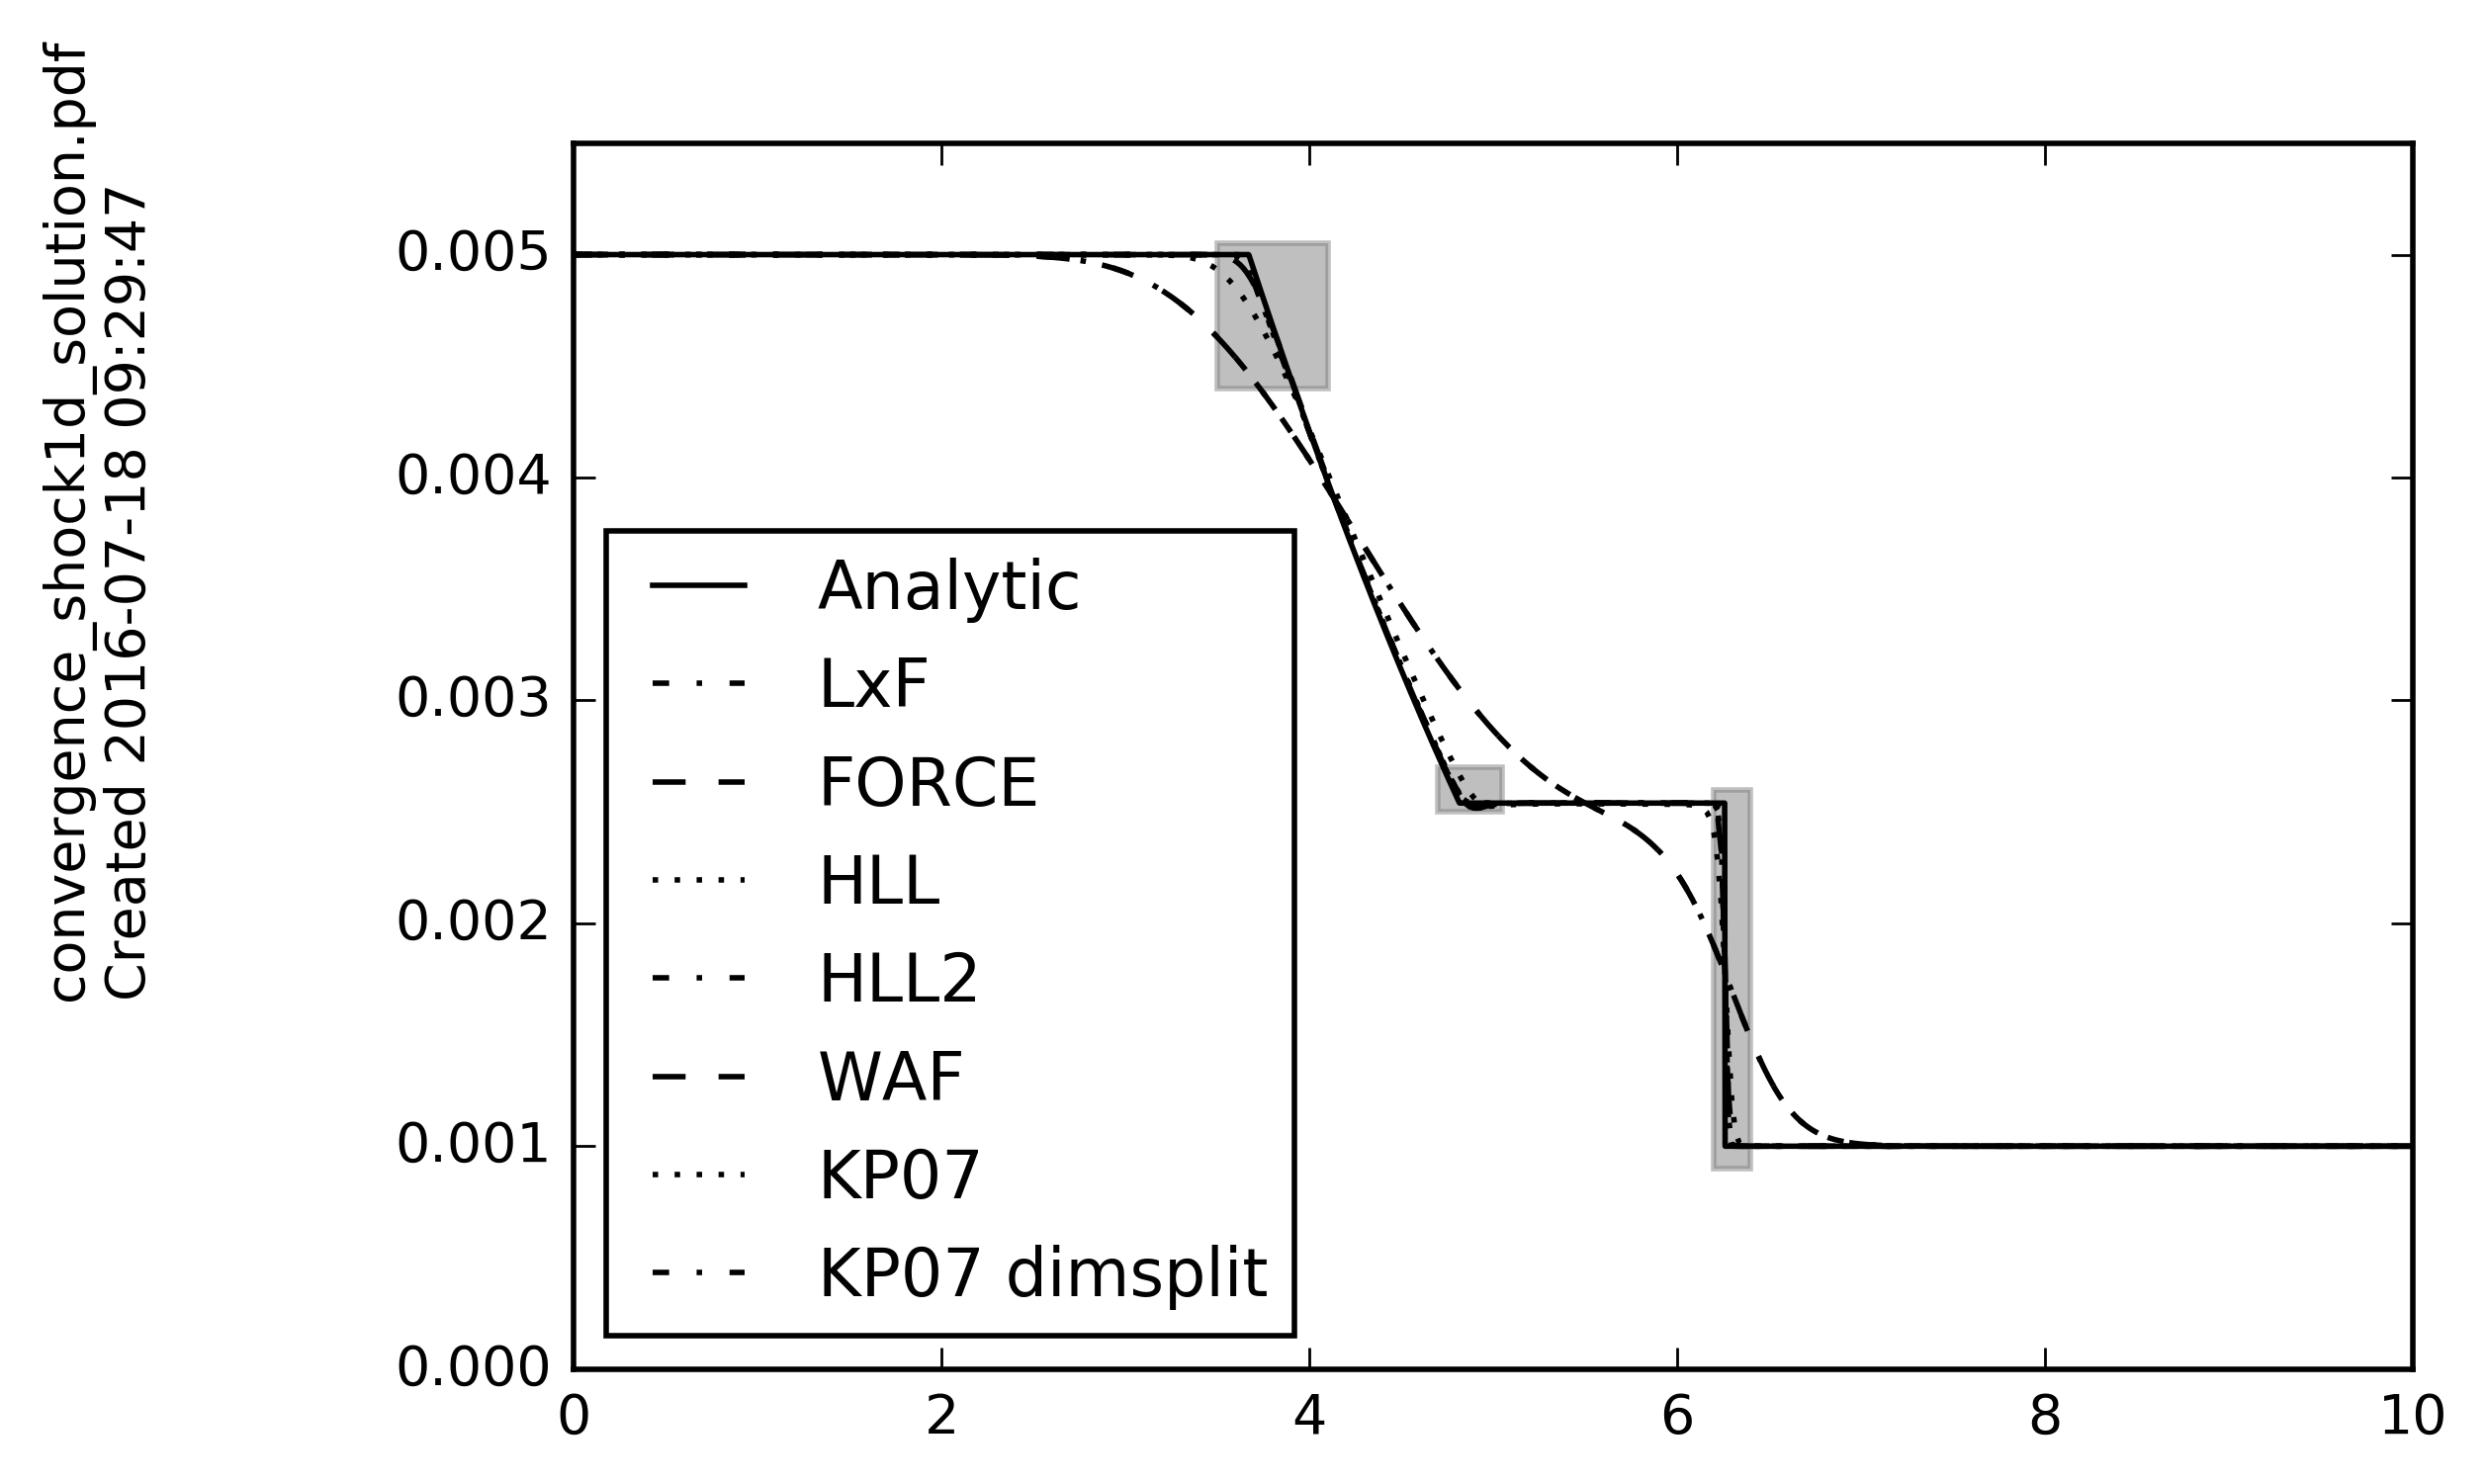

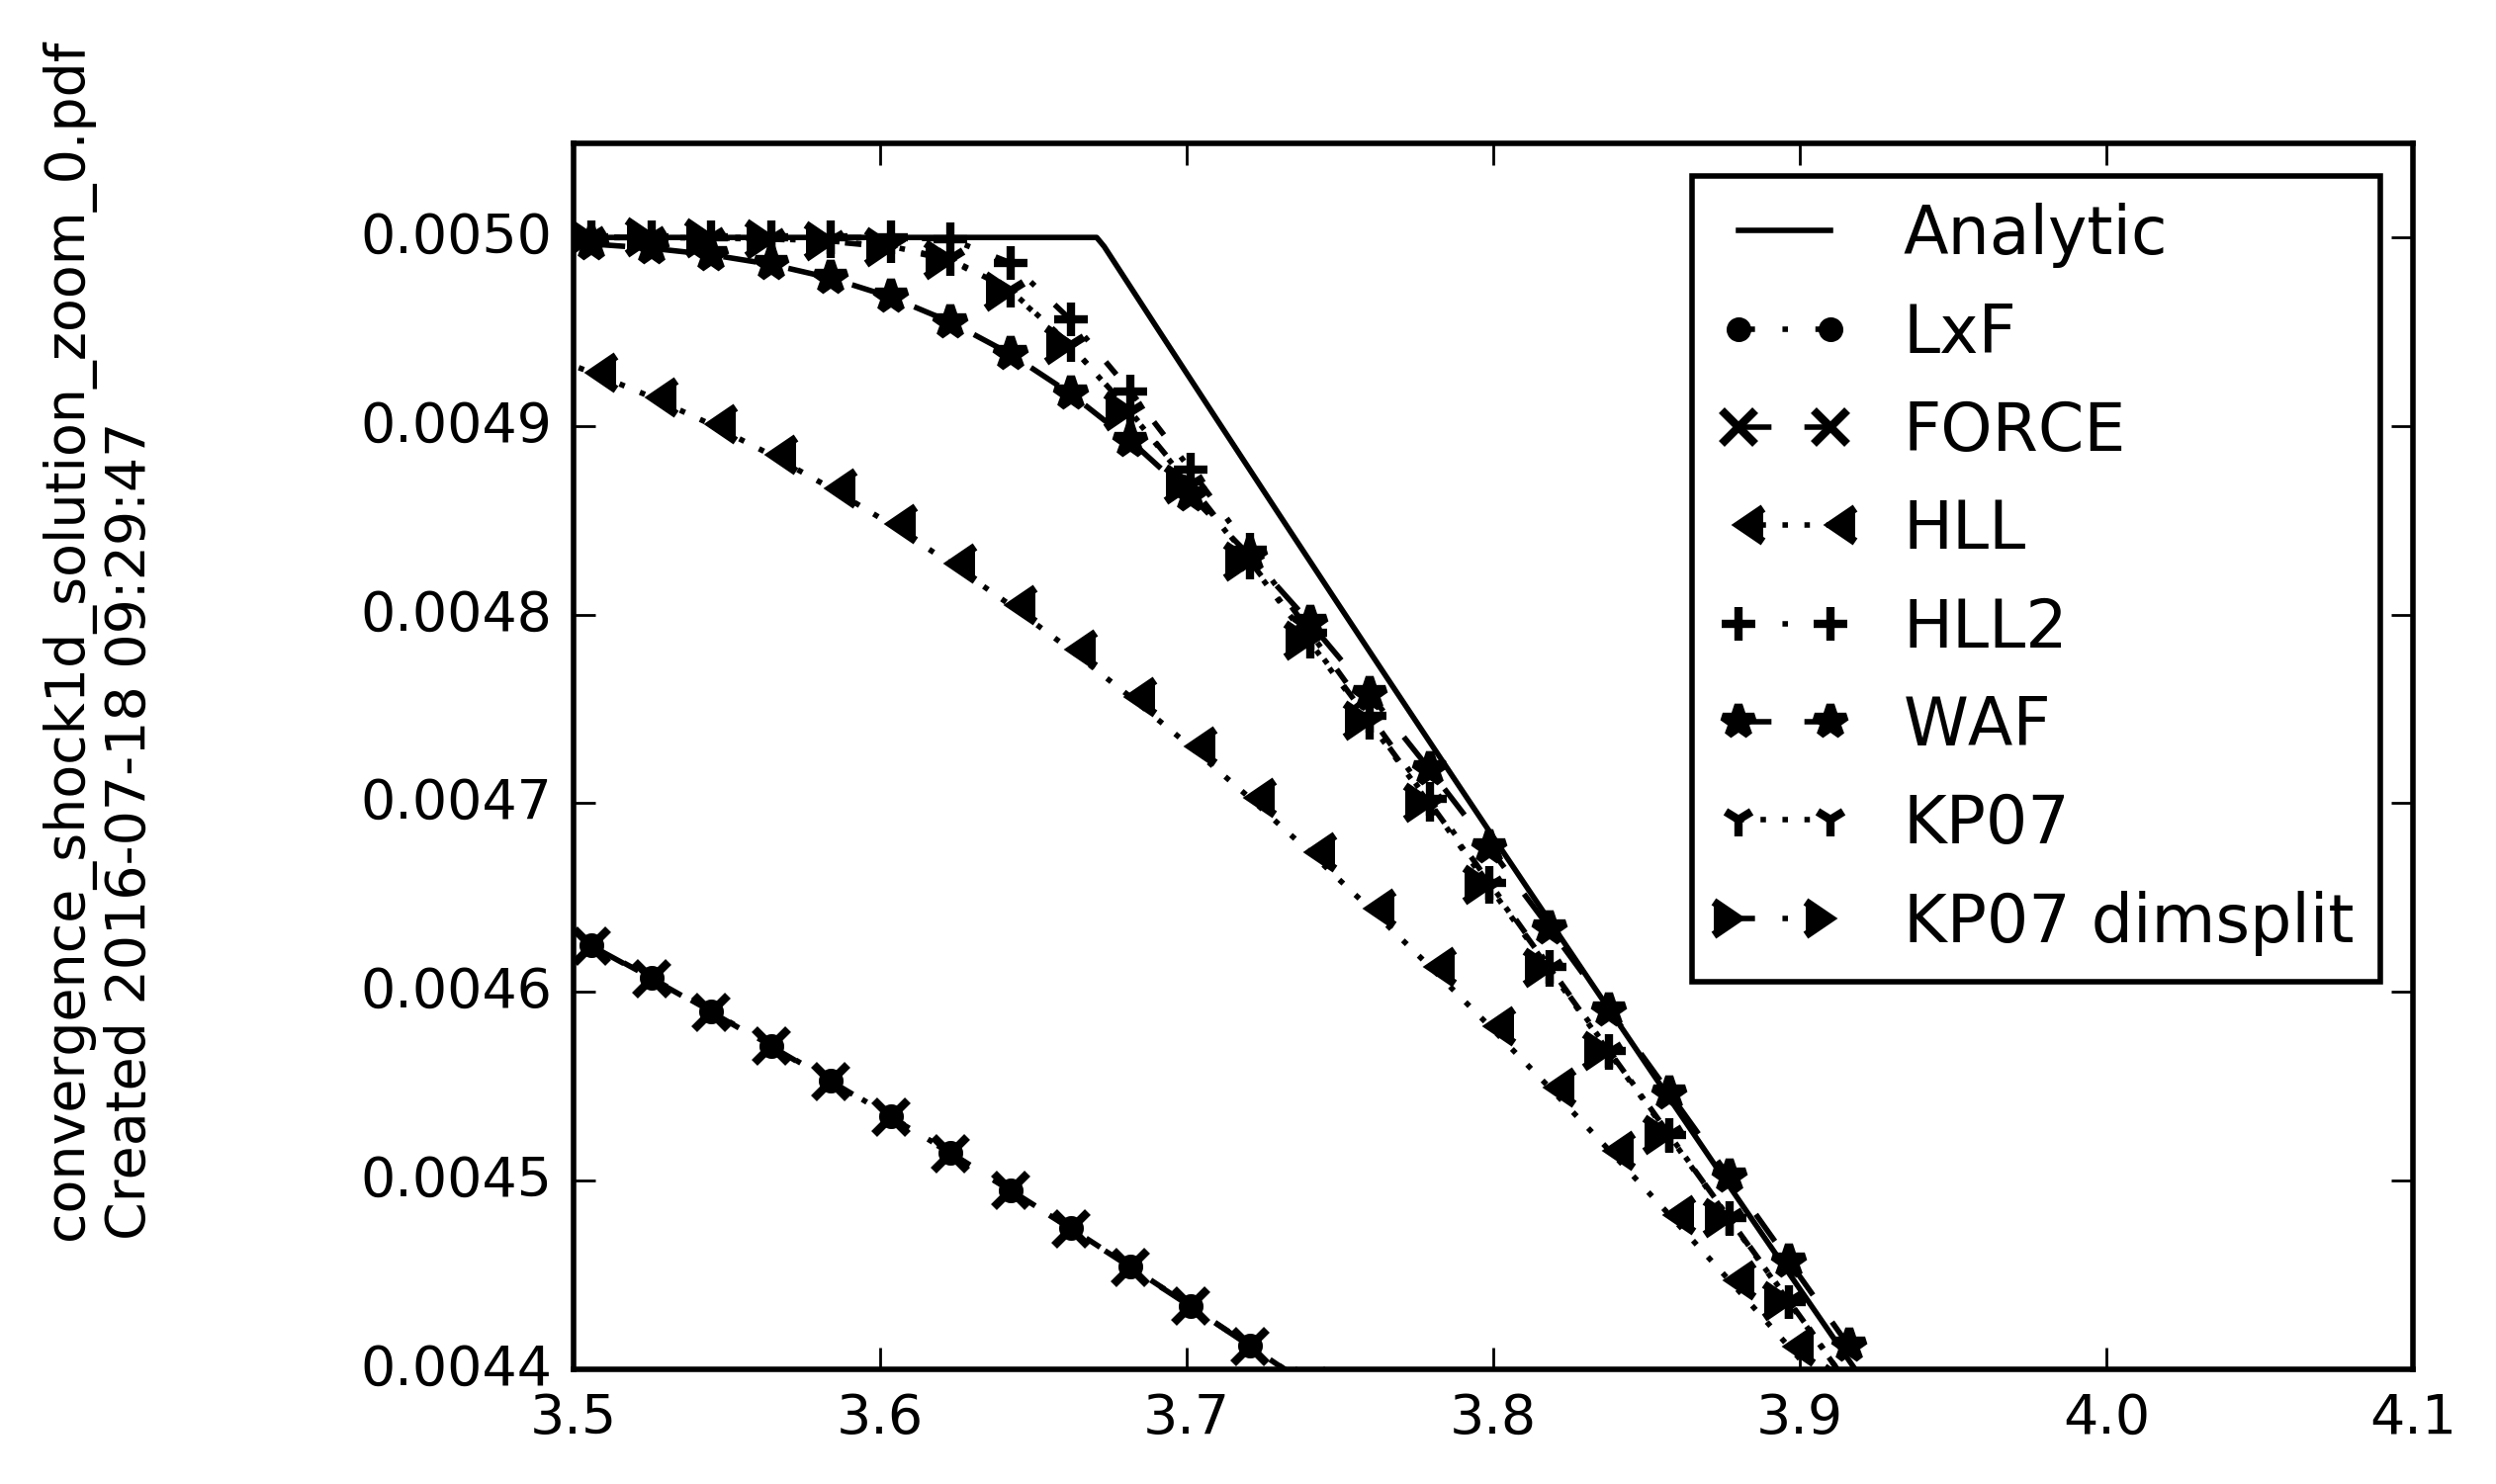

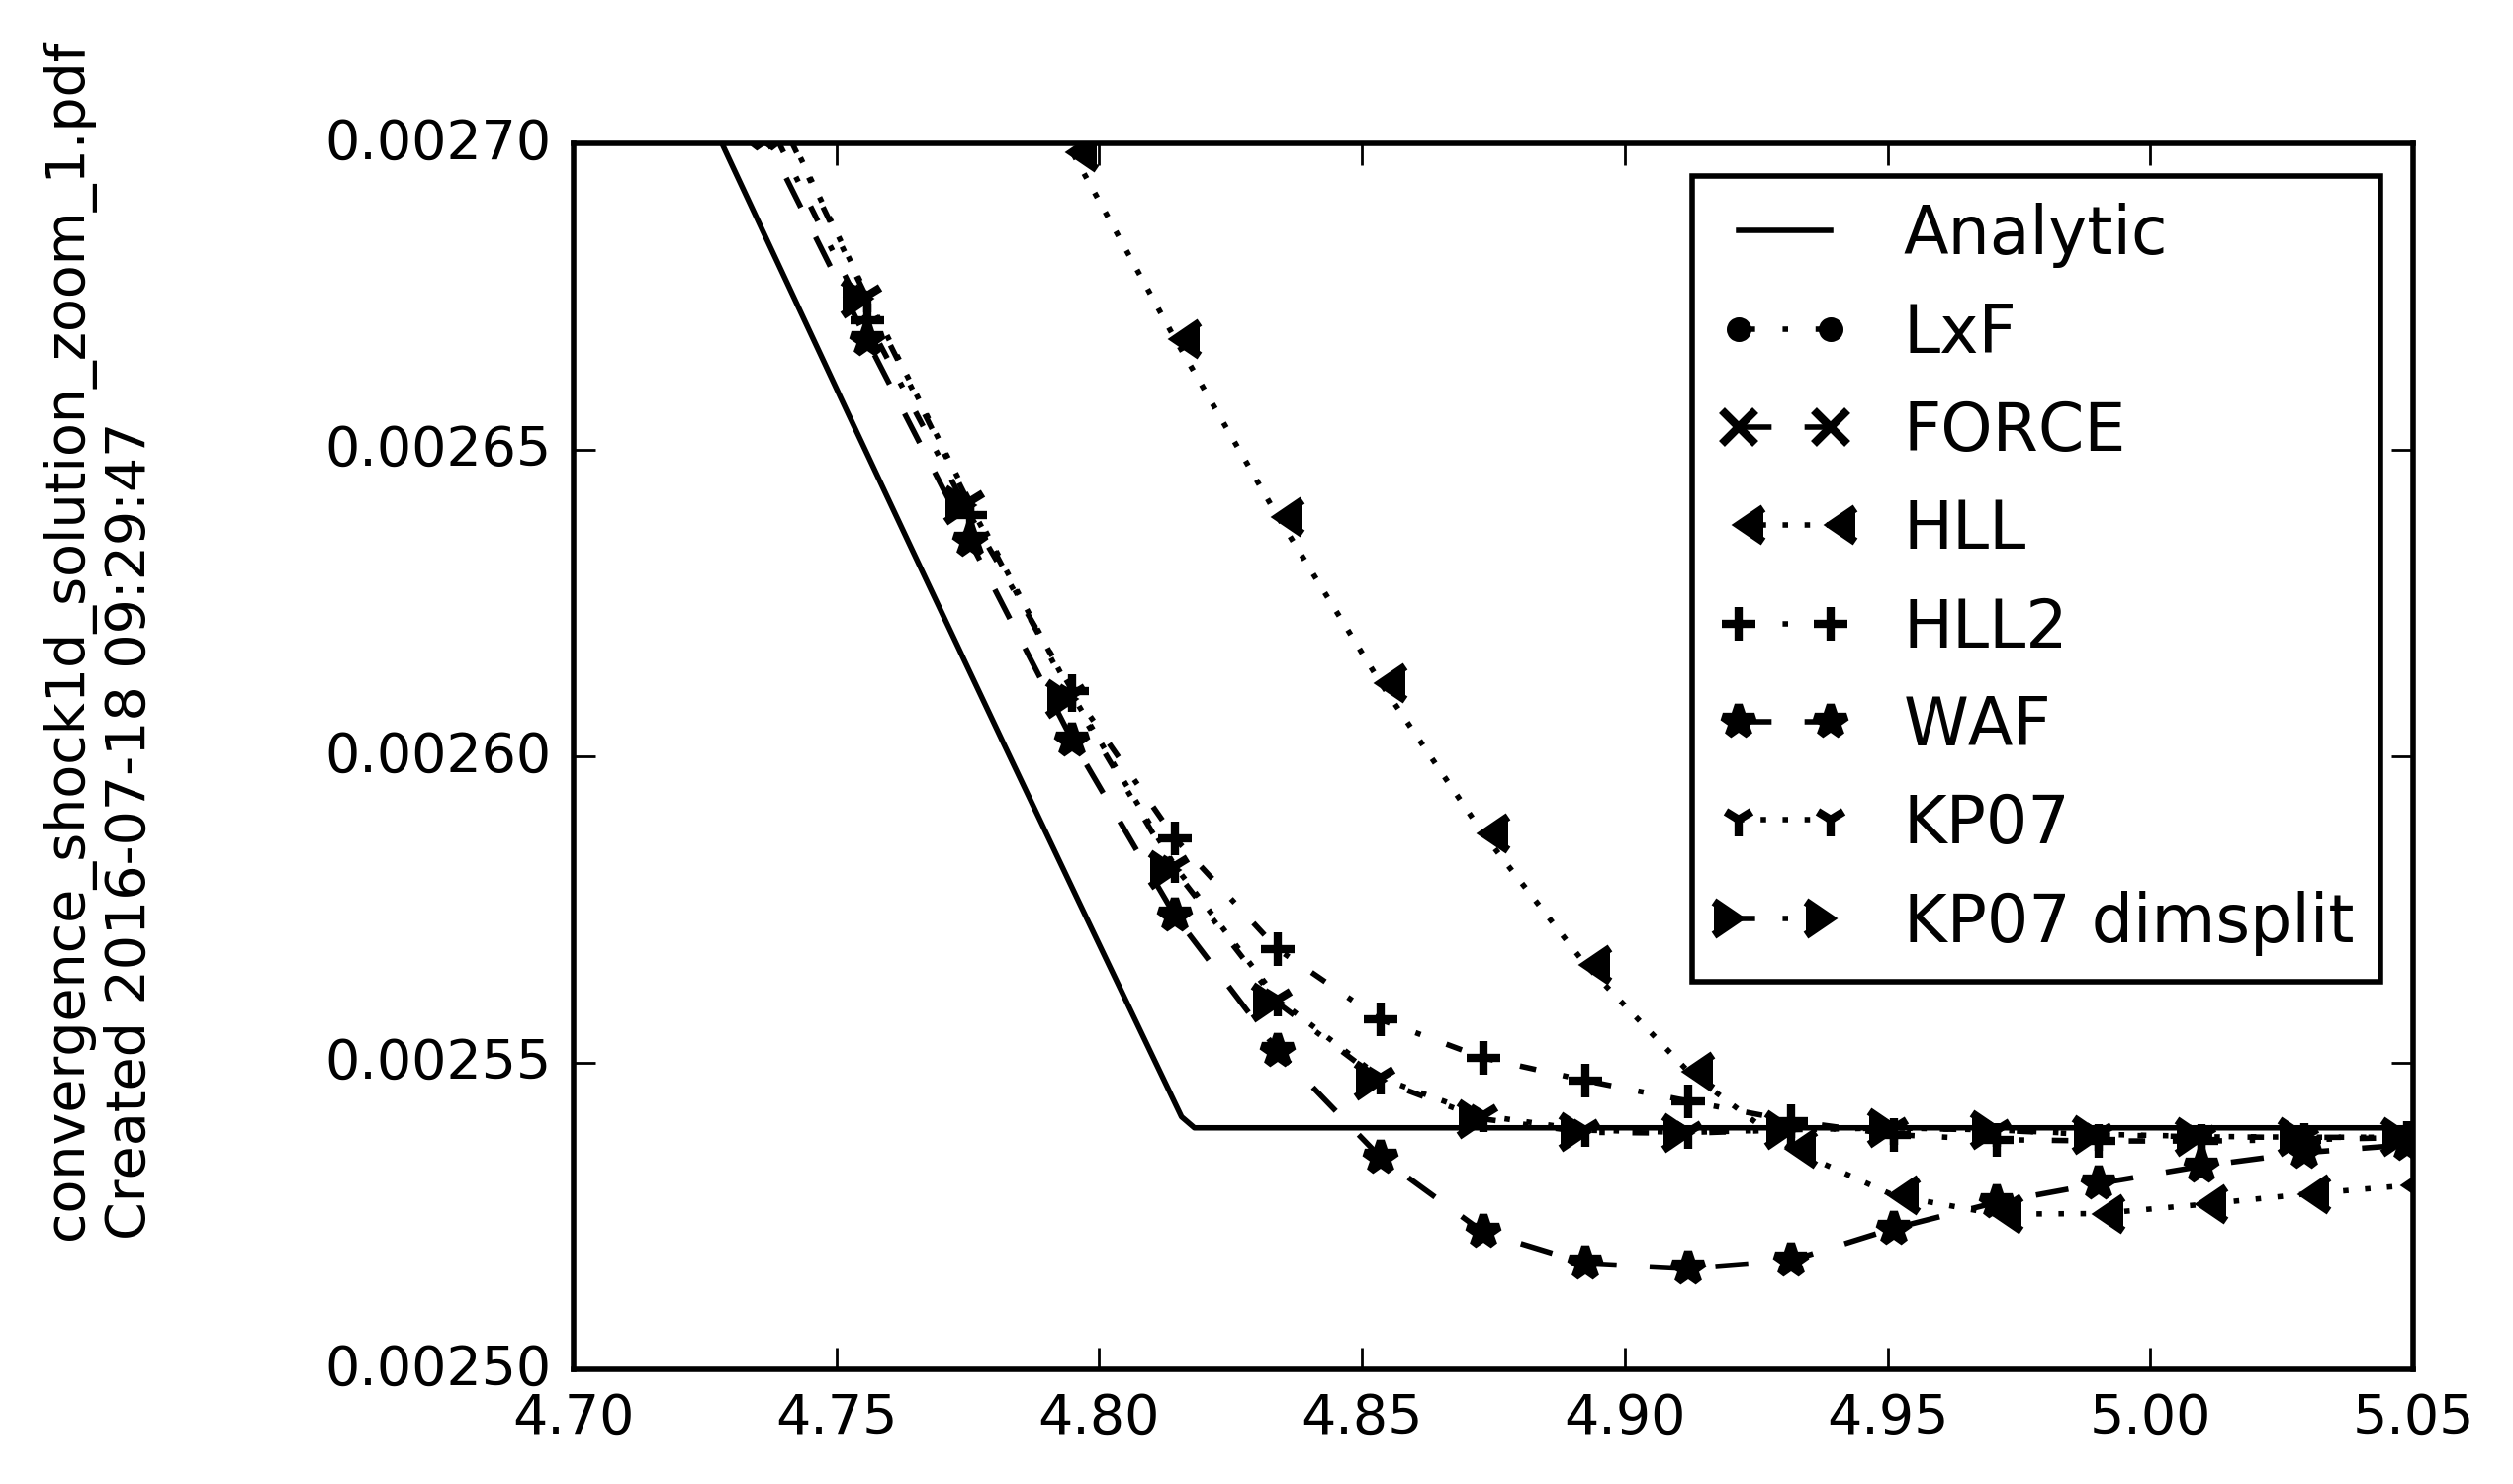

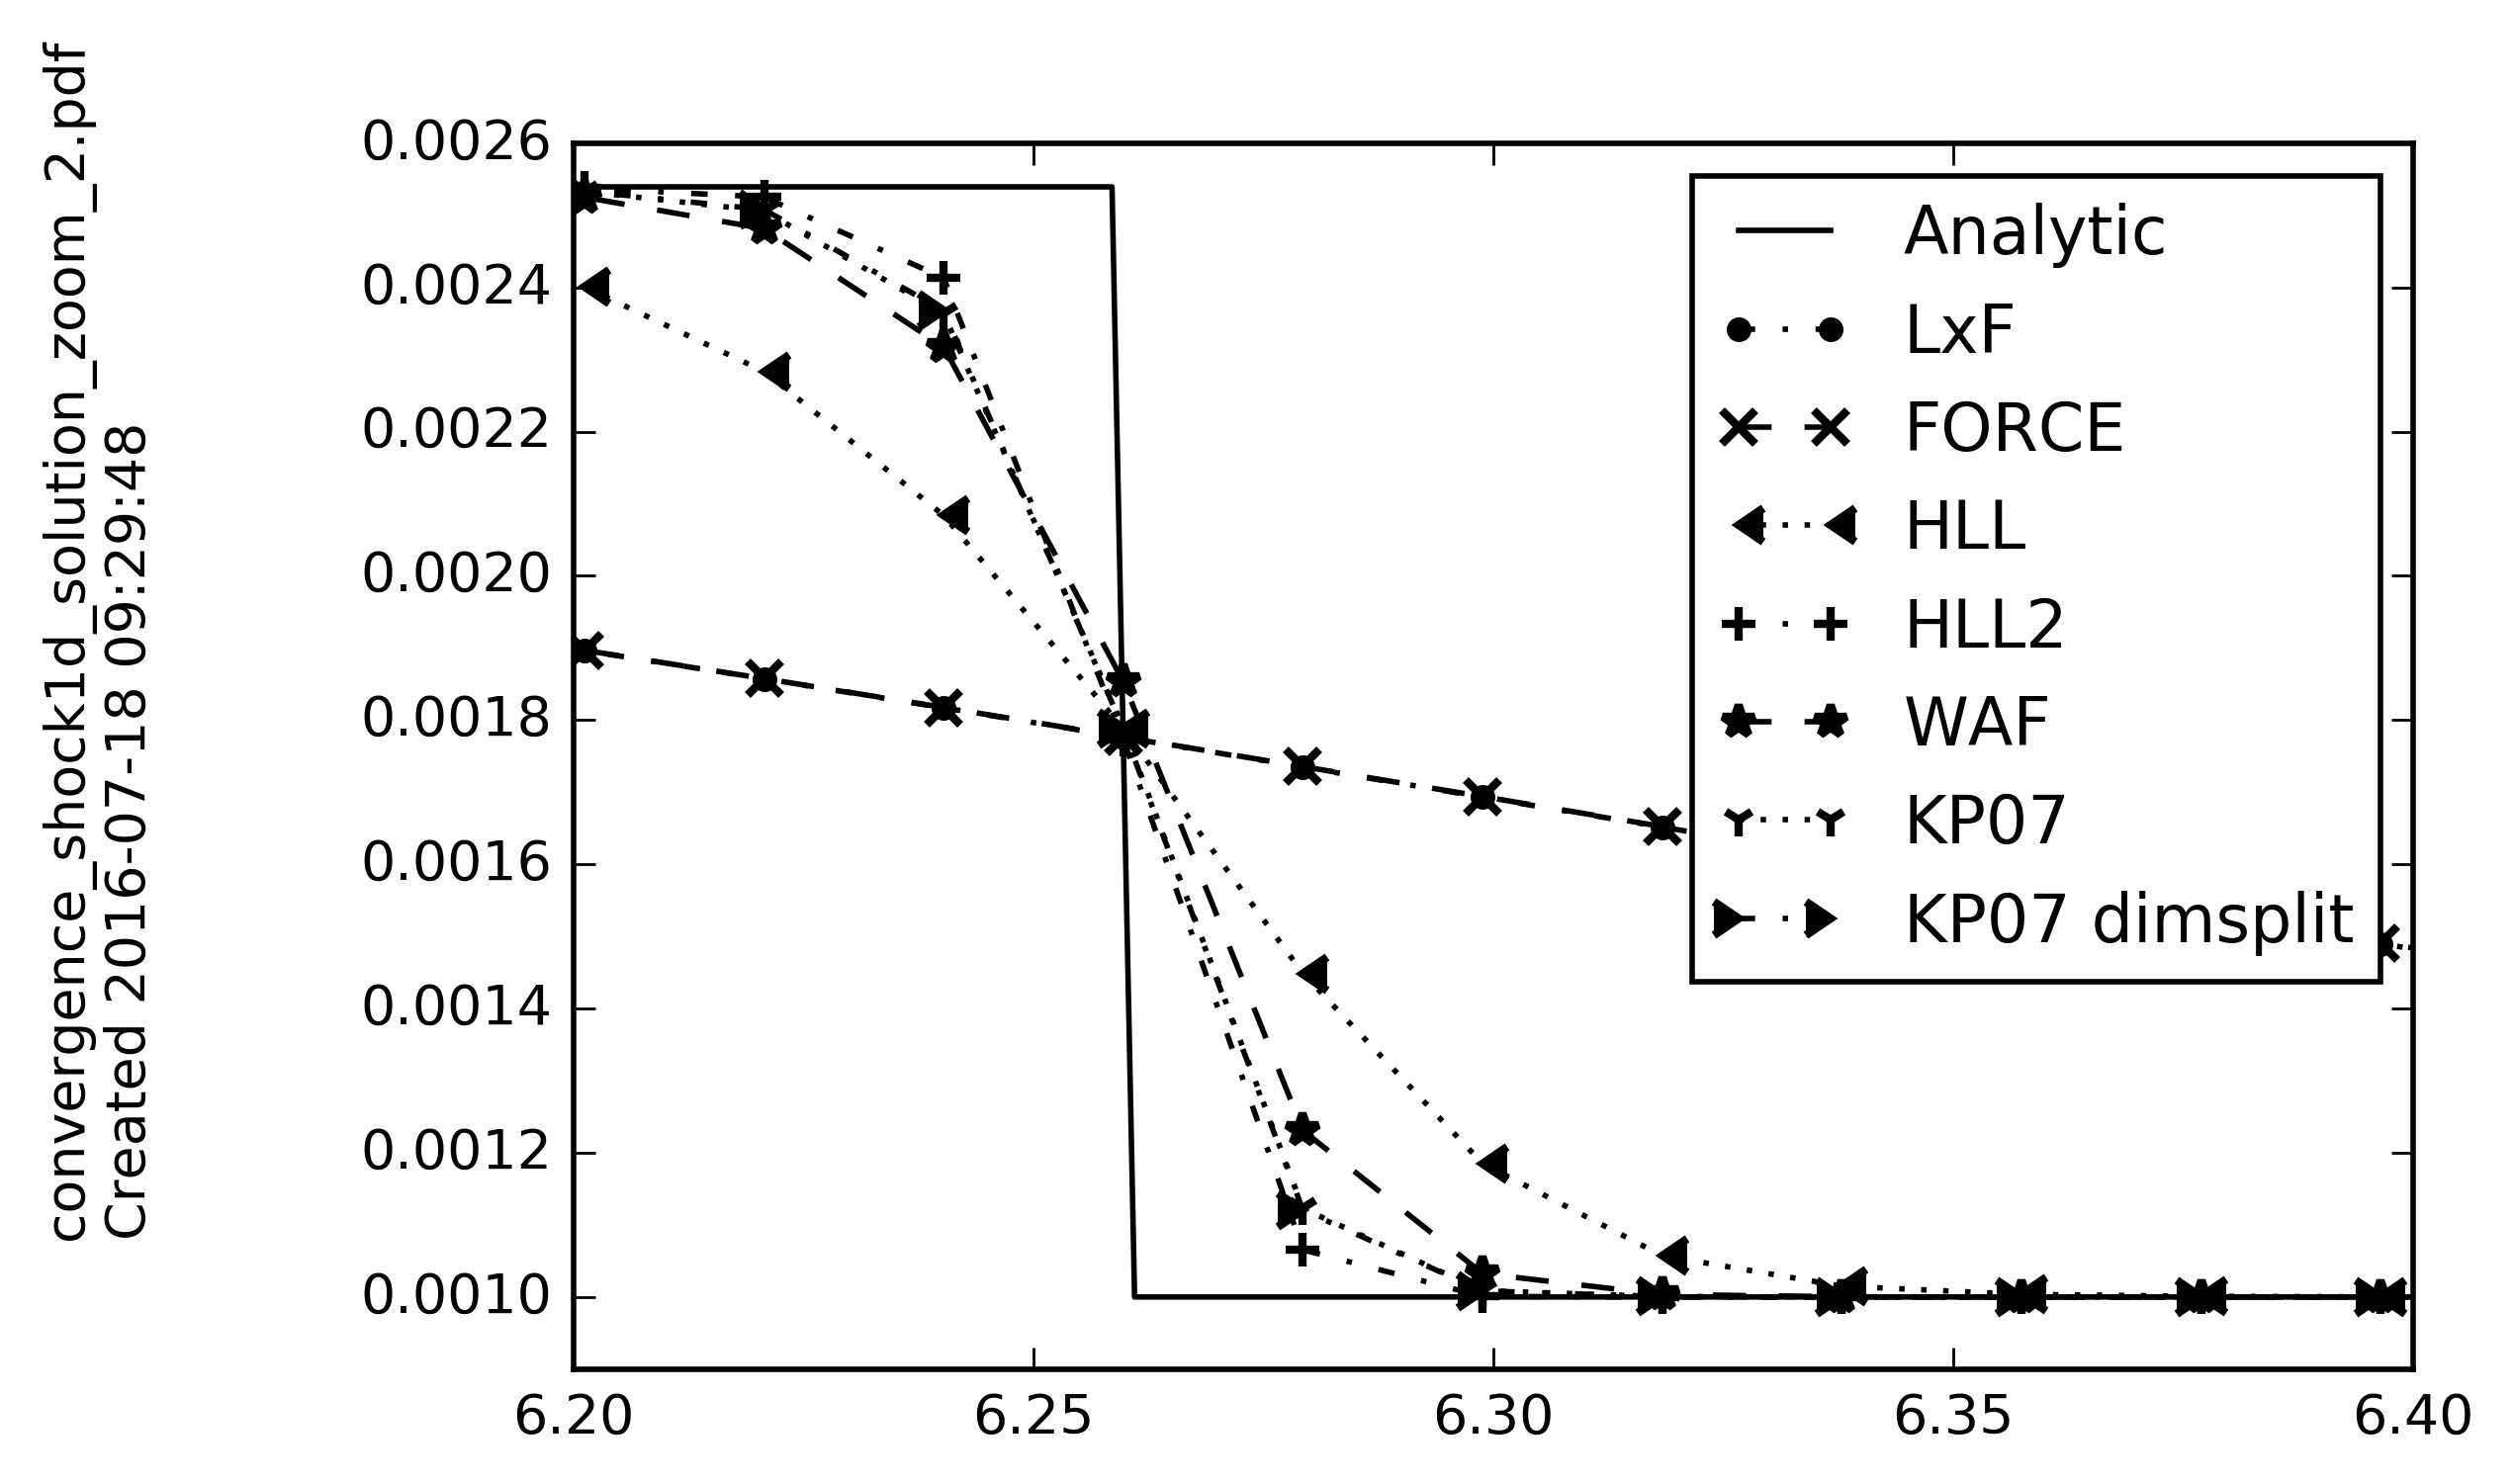

In [15]:
def plot_comparison(marker=None):
    ref_x, ref_h, _ = gen_reference(4096)
    plt.plot(ref_x, ref_h, '-', color='black', label='Analytic')

    for i in range(len(simulators)):

        nx = 512
        x = np.linspace(0.5, nx-0.5, nx)*10.0/float(nx)
        h, _, _ = run_benchmark(simulators[i], \
                                nx, \
                                simulator_ghost_cells[i], \
                                courant_number=simulator_courant_numbers[i], \
                                dt_in=simulator_dt[i])

        #plt.plot(x, h, label=simulator_names[i], drawstyle='steps-mid')
        #plt.plot(x, h, label=simulator_names[i], markevery=(4*i, 32))
        if (marker):
            plt.plot(x, h, label=simulator_names[i], marker=marker)
        else:
            plt.plot(x, h, label=simulator_names[i])
        

fig = plt.figure()
setBwStyles(fig.gca())

boxes = np.array([\
         [[3.5, 4.1], [0.0044, 0.00505]], \
         [[4.7, 5.05], [0.0025, 0.0027]],  \
         [[6.2, 6.40], [0.0009, 0.0026]] \
         ])

plot_comparison(marker=' ')
for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
plt.xlim([0, 10])
plt.ylim([0, 0.0055])
plt.legend(loc='lower left')
save_figure(fig, 'solution')

for i, bbox in enumerate(boxes):
    fig = plt.figure()
    setBwStyles(fig.gca())
    plot_comparison()
    plt.xlim(bbox[0])
    plt.ylim(bbox[1])
    plt.legend()
    
    save_figure(fig, "solution_zoom_" + str(i))
